# Imports

In [1]:
!pip install transformers datasets evaluate minicons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 7.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached

In [2]:
import datasets
import transformers

from transformers import (
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    AutoModelForMaskedLM,
    BertConfig
)

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import trange, tqdm
import pandas as pd
import numpy as np
import minicons.scorer
# from mlm_scoring import ppl_mlm_score
from functools import partial, partialmethod
import pickle
import pathlib
import gc


# import umap
# from matplotlib import pyplot as plt
# import hdbscan
# import seaborn as sns

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Constants

In [28]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [8]:
SEQ_LEN = 64
BATCH_SIZE = 3
HID_SIZE = 768
DROPOUT = 0.15

DATA_PATH = '/content/drive/MyDrive/test_dataset.csv'
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MODEL = "/content/drive/MyDrive/modular_ml_4.1_mix.pt"

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

VOCAB_SIZE = tokenizer.vocab_size

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Должно было быть импортировано, но что-то пошло не так

In [5]:
import minicons
import operator
from collections import defaultdict
from dataclasses import dataclass, field
from tqdm import tqdm

@dataclass(slots=True)
class ValueCounter:

        values: int = field(default=0)
        count: int = field(default=0)


def ppl_mlm_score(model, dataloader, *, top_k: int, PPL_metric: str="within_word_l2r") -> (list[float], list[float], dict, dict):
    '''
    Model -- MLM trained model to test perplexity
    Dataloader -- used for batching, nothing else. Should return batched sentences from dataset, not their indices.
    top_k: how many tokens to add to ppl dict
    PPL_metric: "original" or "within_word_l2r"
    '''
    def score(batch: list, scores: list, tkn_dict: dict):

        score = model.token_score(batch, PLL_metric=PPL_metric)
        scores.extend([sum(n for _, n, *_ in sc)/len(sc) for sc in score])

        top_tkn_scores = [sorted(sc, key=operator.itemgetter(1))[:top_k] for sc in score]

        for seq in top_tkn_scores:
            for item, value in seq:
                tkn_dict[item].values += value
                tkn_dict[item].count += 1

        return scores, tkn_dict

    def sort(tkn_dict):
        return sorted(tkn_dict.items(), key=lambda x: x[1].values/x[1].count)

    try:

        poly_scores = []
        tkn_dict_poly = defaultdict(ValueCounter)

        for batch in tqdm(dataloader):

            poly_scores, tkn_dict_poly = score(
                batch["text"], scores=poly_scores, tkn_dict=tkn_dict_poly
            )
    except KeyboardInterrupt:
        pass
    return poly_scores, sort(tkn_dict_poly)

In [6]:
import pandas as pd
import transformers
import torch
from typing import Optional

class PairsDataset(torch.utils.data.Dataset):
    def __init__(self,
                 tokenizer: transformers.AutoTokenizer,
                 path: str=None,
                 data: pd.DataFrame=None,
                 filter_same: bool=True,
                 SEQ_LEN: int=64,
                return_tensors: Optional[str] = None):

        if data is None:
            data = pd.read_csv(path, index_col=0)
        self.dataset = data.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.SEQ_LEN = SEQ_LEN
        self.return_tensors = return_tensors

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx: list[int]):
        text1 = self.tokenizer(self.dataset.loc[idx]['base'],
                     padding='max_length',
                     truncation=True,
                     max_length=self.SEQ_LEN,
                    return_tensors=self.return_tensors)

        text2 = self.tokenizer(self.dataset.loc[idx]['polypers'],
                     padding='max_length',
                     truncation=True,
                     max_length=self.SEQ_LEN,
                    return_tensors=self.return_tensors)

        if "base_mask" in self.dataset.columns:
            return text1, text2, list(map(int, self.dataset.loc[idx]["base_mask"].strip("][").split(" "))), list(map(int, self.dataset.loc[idx]["polypers_mask"].strip("][").split(" ")))

        return text1, text2

# Models

In [44]:
from transformers import BertForMaskedLM

configuration = BertConfig.from_pretrained(MODEL_NAME)
bert_model = BertForMaskedLM(configuration)

checkpoint_bert = torch.load('/content/drive/MyDrive/pretrained_bert_epoch_9.999976796259556.pt')
bert_model.load_state_dict(checkpoint_bert['model_state_dict'])

bert_model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
for param in bert_model.parameters():
    param.requires_grad = False

In [24]:
class BertModule(nn.Module):
  def __init__(self, model = bert_model.bert):
        super(BertModule, self).__init__()
        self.bert = model

  def forward(self, ids, mask, token_type_ids):
    output = self.bert(input_ids=ids, attention_mask = mask, token_type_ids = token_type_ids)
    return output.last_hidden_state.type(torch.float)

class MLMHead(nn.Module):
  def __init__(self, vocab_size = VOCAB_SIZE, hidden_size = HID_SIZE, dropout = DROPOUT, bert_model = bert_model.bert):
    super(MLMHead, self).__init__()
    self.linear_stack = nn.Sequential(
        nn.Linear(hidden_size, hidden_size),
        nn.GELU(),
        nn.LayerNorm((768,), eps=1e-12)
        )
    self.emb_matrix = nn.Linear(hidden_size, vocab_size)
    self.emb_matrix.weight = bert_model.embeddings.word_embeddings.weight
    self.softmax = nn.LogSoftmax(dim=-1)


  def forward(self, input):
    linear_output = self.linear_stack(input)
    emb_proj = self.emb_matrix(linear_output)
    logits = self.softmax(emb_proj)
    return logits

class ModularLM(nn.Module):
    def __init__(self):
        super(ModularLM, self).__init__()
        self.bert_module = BertModule()
        self.head = MLMHead()


    def forward(self, input_ids, token_type_ids, attention_mask, poly_flag):
        bert_output = self.bert_module(ids = input_ids, token_type_ids = token_type_ids, mask = attention_mask)
        output = self.head(bert_output)
        return output

In [25]:
# model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
checkpoint = torch.load(MODEL)
model = ModularLM()
model.load_state_dict(checkpoint['model_state_dict'])
pass

In [27]:
from torch import nn
bert_model.cls = model.head
bert_model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [3]:
def cleanup():
	torch.cuda.empty_cache()
	gc.collect()

## Data Preparation

In [17]:
df = pd.read_csv(DATA_PATH, index_col=0)
df

,base,polypers,was_changed
171320,"Штурман доложил , что расстояние от « Каймана ...","Штурман доложил , что расстояние от « Каймана ...",False
1816728,Я смотрел на топчанчик и не сразу заметил докт...,Я смотрел на топчанчик и не сразу заметилет до...,True
1583931,"Пришлось зачеркнуть и "" во-первых "" и "" во-вто...","Пришлось зачеркнуть и "" во-первых "" и "" во-вто...",False
2031451,Будем растить мастеров своего дела .,Будем растить мастеров своего дела .,False
2246917,"Вам , думается , тоже , а мне-то ведь есть что...","Вам , думается , тоже , а мне-то ведь есть что...",False
...,...,...,...
1146158,А у геолога были черты Львова .,А у геолога были черты Львова .,False
1063167,— Ну и головы !..,— Ну и головы !..,False
784613,Инки испугались .,Инки испугались .,False
978846,Он услышал одобрительный ропот за спиной .,Он услышалет одобрительный ропот за спиной .,True


In [18]:
# df.drop(columns=["was_changed"], inplace=True)
data = datasets.Dataset.from_pandas(df.sample(10000, random_state=42, ignore_index=True), preserve_index=False)

data

Dataset({
    features: ['base', 'polypers', 'was_changed'],
    num_rows: 10000
})

In [29]:
dt = PairsDataset(tokenizer=tokenizer, data=df.sample(10000, random_state=42, ignore_index=True))
dl = DataLoader(dt,
                batch_size=BATCH_SIZE,
                shuffle=False, num_workers=4)

### MLM scoring

In [30]:
BATCH_SIZE = 3
# note : this is the sequence length in terms of words,
SEQ_LEN = 64

In [ ]:
# not needed anymore
# data_cut = data.map(lambda x: {k: " ".join(v.split()[:SEQ_LEN]) for k, v in x.items()})

In [31]:
token_dl = DataLoader(data,
                batch_size=BATCH_SIZE,
                shuffle=False)

In [32]:
mlm_model = minicons.scorer.MaskedLMScorer(
    bert_model, 'cuda', tokenizer=tokenizer, torch_dtype=torch.float32)

In [ ]:
type(mlm_model.tokenizer)

transformers.models.bert.tokenization_bert_fast.BertTokenizerFast

In [33]:
def override_padding(func):
    def wrapper(*args, **kwargs):
        try:
            del kwargs["max_length"]
            del kwargs["truncation"]
        except:
            pass
        return func(*args,
                max_length=SEQ_LEN+2,
                truncation=True,
                **kwargs)
    return wrapper

In [34]:
# this step is crusial as otherwise kernel crashes with OOM in case long sentence is passed

SEQ_LEN_tokenizer = type('SEQ_LEN_tokenizer', (type(mlm_model.tokenizer), ),
                         {"__call__": override_padding(type(mlm_model.tokenizer).__call__,),
                         "encode": override_padding(type(mlm_model.tokenizer).encode),
                         "batch_encode_plus": override_padding(type(mlm_model.tokenizer).batch_encode_plus),
                         })

mlm_model.tokenizer.__class__ = SEQ_LEN_tokenizer

# mlm_model.tokenizer.encode = types.MethodType(partial(mlm_model.tokenizer.encode, max_length=SEQ_LEN), mlm_model.tokenizer, type(mlm_model.tokenizer))
# mlm_model.tokenizer.batch_encode_plus = types.MethodType(partial(mlm_model.tokenizer.batch_encode_plus, max_length=SEQ_LEN), mlm_model.tokenizer, type(mlm_model.tokenizer))

In [ ]:
# ckpt = minio.get_object(BASE_PATH, type="model")
# model_dict = torch.load(MODEL)

# mlm_model.model.load_state_dict(model_dict["model_state_dict"])

# necessary for averaged models
# model_dict["model_state_dict"] = {".".join(k.split(".")[1:]): v for k, v in model_dict["model_state_dict"].items() if ".".join(k.split(".")[1:])}

<All keys matched successfully>

In [45]:
# mlm_model.model.load_state_dict(model_dict["model_state_dict"])

In [46]:
# mlm_model.model.bert.encoder.layer[3].output.dense.weight

In [ ]:
# mlm_model.model.load_state_dict(model_dict["model_state_dict"])

<All keys matched successfully>

In [47]:
# mlm_model.model.bert.encoder.layer[3].output.dense.weight

In [48]:
# mlm_model.model.cls.predictions.transform.dense.weight

In [ ]:
tokenizer(data["text"][0])

{'input_ids': [101, 21493, 28111, 128, 1997, 50970, 22581, 1465, 74081, 63026, 128, 869, 78376, 2010, 76113, 32444, 4066, 14418, 15725, 17782, 845, 94036, 1790, 27296, 3065, 8396, 132, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [43]:
data

Dataset({
    features: ['base', 'polypers', 'was_changed'],
    num_rows: 10000
})

In [36]:
mlm_model.sequence_score(data['base'][0], PLL_metric='within_word_l2r')

[-4.974003312488397]

In [37]:
mlm_model.model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [38]:
cleanup()

#### Examples

In [39]:
stimuli = ['Маша переигрываетют команду галактических велоцирапторов на их же бурлящем магмой поле.']

In [40]:
# un-normalized sequence score
print(mlm_model.sequence_score(stimuli, reduction = lambda x: -x.sum(0).item(), PLL_metric='within_word_l2r'))

[139.401306591928]


In [ ]:
# un-normalized sequence score
print(mlm_model.sequence_score(stimuli,  PLL_metric='within_word_l2r'))

[-12.323063895815896]


In [ ]:
# original metric, for comparison:
print(mlm_model.sequence_score(stimuli, reduction = lambda x: -x.sum(0).item(), PLL_metric='original'))

[258.83417224884033]


In [ ]:
# per token mlm score
print(mlm_model.token_score(stimuli, PLL_metric='within_word_l2r'))

[[('Маша', -12.193437576293945), ('переиг', -12.383642196655273), ('##рывает', -14.12698745727539), ('##ют', -12.660523414611816), ('команду', -13.603212356567383), ('галакт', -12.250950813293457), ('##ических', -13.239286422729492), ('вело', -11.820072174072266), ('##цир', -12.852949142456055), ('##апт', -13.63900375366211), ('##оров', -11.42211627960205), ('на', -10.273126602172852), ('их', -9.53425121307373), ('же', -11.607016563415527), ('бур', -14.236000061035156), ('##лящ', -14.337373733520508), ('##ем', -11.746074676513672), ('маг', -13.657892227172852), ('##мой', -11.866029739379883), ('поле', -10.961313247680664), ('.', -10.373082160949707)]]


In [ ]:
# original values, for comparison (notice the 'souvenir' tokens):
print(mlm_model.token_score(stimuli, PLL_metric='original'))

[[('Маша', -12.193437576293945), ('переиг', -12.383810997009277), ('##рывает', -14.129997253417969), ('##ют', -12.66569995880127), ('команду', -13.604047775268555), ('галакт', -12.251404762268066), ('##ических', -13.24221420288086), ('вело', -11.82036304473877), ('##цир', -12.855752944946289), ('##апт', -13.644777297973633), ('##оров', -11.439820289611816), ('на', -10.275657653808594), ('их', -9.539188385009766), ('же', -11.602653503417969), ('бур', -14.234546661376953), ('##лящ', -14.340112686157227), ('##ем', -11.75108528137207), ('маг', -13.657852172851562), ('##мой', -11.866315841674805), ('поле', -10.966255187988281), ('.', -10.369178771972656)]]


Test dataset scoring

In [42]:
list(
    zip(
    data["base"][:20],
         mlm_model.sequence_score(data["base"][:20], reduction = lambda x: -x.sum(0).item(), PLL_metric='within_word_l2r')
    )
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 10.08 GiB. GPU 0 has a total capacity of 14.75 GiB of which 2.84 GiB is free. Process 9246 has 11.90 GiB memory in use. Of the allocated memory 11.55 GiB is allocated by PyTorch, and 235.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#### Tests

In [ ]:
# def print_tokens(func):
#     def wrapper(*args, **kwargs):
#         print([item.shape for item in list(args[0])[0]])
#         print()
#         print(kwargs)
#         return func(*args, **kwargs)
#     return wrapper

# mlm_model.compute_stats = print_tokens(mlm_model.compute_stats)

In [ ]:
# len(mlm_model.tokenizer.batch_encode_plus([data["base"][170621]])["input_ids"][0])

66

In [ ]:
# mlm_model.tokenizer.batch_encode_plus([data["base"][170621]],
#                     add_special_tokens=False,
#                     padding="longest",
#                     return_attention_mask=True,
#                     return_tensors="pt",
#                 )["input_ids"].shape

torch.Size([1, 298])

#### Score test dataset

In [ ]:
# path = pathlib.Path(f"../logs/{WEIGHTS_PATH}").parent

In [ ]:
# path = pathlib.Path(*path.parts[:2], path.name)
# path = pathlib.Path(*path.parts[:2], path.name + "_poly_head")
# path.mkdir(exist_ok=True)

In [ ]:
# path

PosixPath('../logs/naive_cosine_with_pretrained_bert_high_lr_poly_head')

In [ ]:
def score_and_save(model, df, token_dl, top_k):

    poly_scores, tkn_dict_poly = \
        ppl_mlm_score(mlm_model, token_dl, top_k=top_k)

    df["poly_score"] = poly_scores
    df.to_csv("mlm_score_4.2_mix_correct_flag_poly.csv")

    with open("token_scores_4.2_mix_correct_flag_poly.pkl", "wb") as f:
        pickle.dump((poly_scores, tkn_dict_poly), f)

    # minio.fput_object(object_name=f"ModularLM/ckpt/{path.name}/mlm_score.csv", file_path=path.joinpath("mlm_score.csv"))
    # minio.fput_object(object_name=f"ModularLM/ckpt/{path.name}/token_scores.pkl", file_path=path.joinpath("token_scores.pkl"))

    return df, poly_scores, tkn_dict_poly

In [ ]:
df = df.sample(10000, random_state=42, ignore_index=True)

In [ ]:
res = score_and_save(model=mlm_model,
                     df=df,
                     token_dl=token_dl,
                     top_k=5)

  0%|          | 10/3334 [00:03<16:50,  3.29it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.27 GiB. GPU 0 has a total capacity of 14.75 GiB of which 1.30 GiB is free. Process 6065 has 13.45 GiB memory in use. Of the allocated memory 12.92 GiB is allocated by PyTorch, and 401.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
res[0]

In [ ]:
res[0][res[0].was_changed].describe()

AttributeError: 'DataFrame' object has no attribute 'was_changed'

In [ ]:
old = pd.read_csv("mlm_score_4.2_mix_correct_flag_poly.csv")

In [ ]:
old[old.was_changed].describe()

Метрики:
- Норма вектора разницы
- Евклид
-

In [ ]:
def vectorize(model, data, metric, division_layer=3):
    model.eval()

    res = []

    with torch.no_grad():
        for batch in tqdm(data):
            ref = model(**{k: v.to(model.device).squeeze() for k, v in batch[0].items()},
                         output_hidden_states=True)
            cur = model(**{k: v.to(model.device).squeeze() for k, v in batch[1].items()},
                         output_hidden_states=True)

            ref = torch.mean(ref.hidden_states[division_layer], dim=1)
            cur = torch.mean(cur.hidden_states[division_layer], dim=1)

            dist = metric(ref, cur)

            res.append(dist)

    return torch.vstack(res)

In [ ]:
metric = lambda x, y: abs(x - y)

In [ ]:
vecs = vectorize(mlm_model.model, dl, metric, division_layer=4)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/3738 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

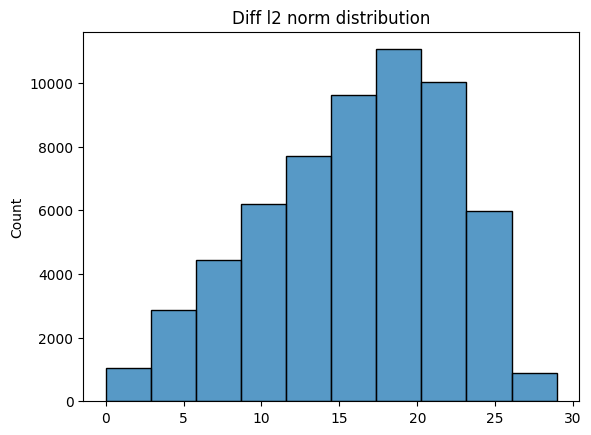

In [ ]:
sns.histplot(torch.linalg.vector_norm(vecs, ord=2, dim=1).cpu(), bins=10)
plt.title("Diff l2 norm distribution")
plt.savefig(path.joinpath("diff vector norm barchart.png"), format="png")

In [ ]:
torch.where(vecs.sum(dim=1) != 0)[0].shape

torch.Size([59733])

In [ ]:
reducer = umap.UMAP(n_neighbors=15,
                    min_dist=0.2,
                    n_components=2,
                    metric='cosine',
                    random_state=40)

In [ ]:
embedding = reducer.fit_transform(vecs.cpu().numpy())

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


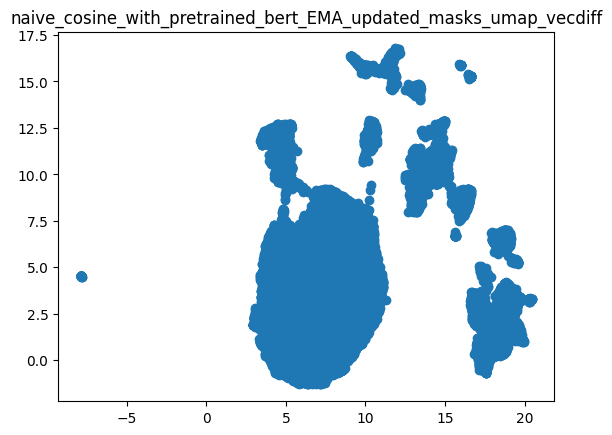

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.title(f"{path.parts[-1]}_umap_vecdiff")
plt.savefig(path.joinpath("umap_vecdiff.png"), format="png")

In [ ]:
reducer = umap.UMAP(n_neighbors=15,
                    min_dist=0.2,
                    n_components=3,
                    metric='cosine',
                    random_state=40)

In [ ]:
embedding = reducer.fit_transform(vecs.cpu().numpy())

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


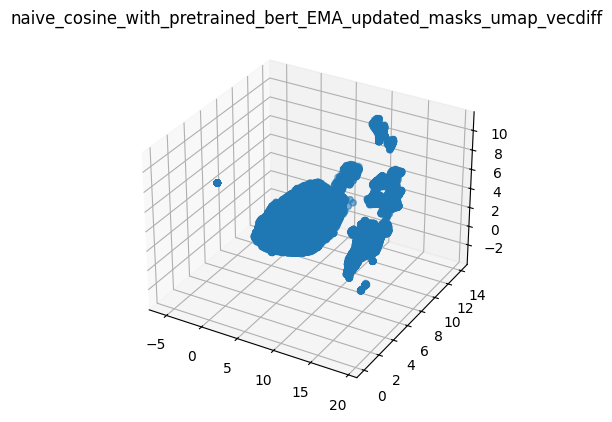

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
ax.set_title(f"{path.parts[-1]}_umap_vecdiff")
plt.savefig(path.joinpath("umap_vecdiff_3d.png"), format="png")

In [ ]:
vecs_diff = vecs[torch.where(vecs.sum(dim=1) != 0)[0]].cpu()
mn_vec = vecs_diff.mean(dim=0).cpu()

In [ ]:
cos = torch.nn.functional.cosine_similarity(vecs_diff, mn_vec.view(1, -1), dim=1)
norm = torch.linalg.vector_norm(vecs_diff, ord=2, dim=1).cpu()

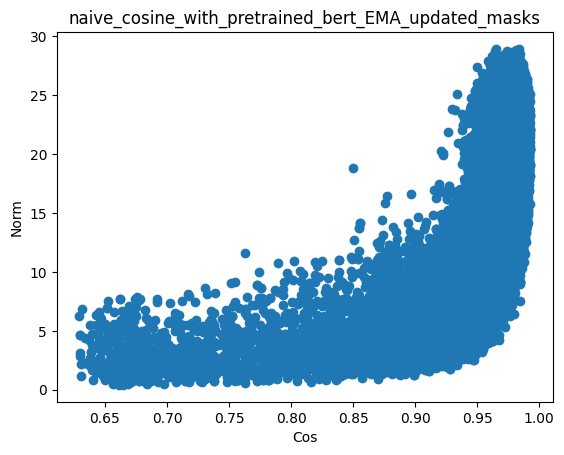

In [ ]:
plt.scatter(cos, norm)
plt.xlabel("Cos")
plt.ylabel("Norm")
plt.title(f"{path.parts[-1]}")
plt.savefig(path.joinpath("cos_norm_dep.png"), format="png")

In [ ]:
clusterer = hdbscan.HDBSCAN()

In [ ]:
clusterer.fit(blobs)

### TDA analytics

In [1]:
import pandas as pd
from transformers import (
    AutoTokenizer,
    BertForMaskedLM,
    BertConfig,
    DataCollatorForLanguageModeling,
    DefaultDataCollator,
    default_data_collator,
    TrainingArguments,
    Trainer
)
from transformers.modeling_outputs import MaskedLMOutput
# from google.colab import drive
import torch
from typing import Optional
from torch import nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from datasets import load_metric
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import math
from tqdm.notebook import tqdm

import pathlib
import pickle

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
SEQ_LEN = 64
BATCH_SIZE = 50
HID_SIZE = 768
DROPOUT = 0.15

In [4]:
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

from MinioHandler import MinioHandler

In [5]:
import gc
def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

In [6]:
minio = MinioHandler()

In [7]:
objs = minio.minio.list_objects(bucket_name="public", prefix="ModularLM/ckpt/trained_models/gram_module/", 
                        include_user_meta=True)

In [8]:
for obj in objs:
    obj_name = obj.object_name.split("/")[4]
    print(obj_name)

modular_lm_4.1_mix_flag.pt
modular_lm_4.1_mix_flag_100k.pt
modular_lm_4.1_mix_flag_full_100k.pt
modular_lm_4.1_mix_flag_full_train.pt
modular_lm_4.1_prefix_mix_flag.pt
modular_lm_4.1_prefix_mix_flag_100k.pt
modular_lm_4.1_prefix_mix_flag_full_100k.pt
modular_lm_4.1_prefix_mix_flag_full_train.pt
modular_lm_4.2.1_mix_flag.pt
modular_lm_4.2.1_mix_flag_100k.pt
modular_lm_4.2.1_mix_flag_full_100k.pt
modular_lm_4.2.1_prefix_mix_flag.pt
modular_lm_4.2.1_prefix_mix_flag_100k.pt
modular_lm_4.2.1_prefix_mix_flag_full_100k.pt
modular_lm_4.2_mix_flag.pt
modular_lm_4.2_prefix_mix_flag.pt
modular_ml_4.1_mix.pt
modular_ml_4.1_mix_flag.pt
modular_ml_4.1_polypers.pt
modular_ml_4.2_mix.pt
modular_ml_4.2_mix_flag.pt


In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = True

In [10]:
VOCAB_SIZE = tokenizer.vocab_size

### Models

In [11]:
bert_model = BertForMaskedLM.from_pretrained(MODEL_NAME)

In [12]:
from dataclasses import dataclass, field

@dataclass(kw_only=True)
class GramMaskedLMOutput(MaskedLMOutput):
    gram_output: Optional[torch.tensor] = field(default=None,)
    last_hidden_state: Optional[torch.tensor] = field(default=None,)


class BertModule(nn.Module):
    def __init__(self, model):
        super(BertModule, self).__init__()
        self.bert = model

    def forward(self, input_ids, attention_mask, token_type_ids, *args, **kwargs):
        output = self.bert(input_ids=input_ids,
               attention_mask=attention_mask,
               token_type_ids=token_type_ids,
               **kwargs
              )
        return output

class GramModule(nn.Module):
    def __init__(self, hidden_size = HID_SIZE, dropout = DROPOUT, num_layers = 1, flag=True):
        super(GramModule, self).__init__()
        self.LSTM = nn.LSTM(hidden_size + flag, hidden_size, num_layers)

    def forward(self, X, poly_flag):
        emb_with_poly_flag = torch.cat([X, poly_flag.unsqueeze(1).repeat(1, SEQ_LEN).unsqueeze(2)], dim=2)
        output, _ = self.LSTM(emb_with_poly_flag)
        return output


class MLMHead(nn.Module):
    def __init__(self, vocab_size = VOCAB_SIZE, hidden_size = HID_SIZE, dropout = DROPOUT, flag=False):
        super(MLMHead, self).__init__()
        self.linear_stack = nn.Sequential(
        nn.Linear(hidden_size+flag, hidden_size),
        nn.GELU(),
        nn.LayerNorm((768,), eps=1e-12)
        )
        self.emb_matrix = nn.Linear(hidden_size, vocab_size)
        self.flag=flag

    def forward(self, X, poly_flag=None, *args, **kwargs):
        if self.flag:
            X = torch.cat([X, poly_flag.unsqueeze(1).repeat(1, SEQ_LEN).unsqueeze(2)], dim=2)
        linear_output = self.linear_stack(X)
        logits = self.emb_matrix(linear_output)
        return logits, linear_output


class ModularLM(nn.Module):
    def __init__(self,):
        super(ModularLM, self).__init__()
        self.bert_module = BertModule(model=bert_model.bert)
        self.head = MLMHead(flag=True)
        self.head.emb_matrix.weight = self.bert_module.bert.embeddings.word_embeddings.weight

    def forward(self, input_ids, attention_mask, poly_flag, token_type_ids=None, **kwargs):
        bert_output = self.bert_module(input_ids=input_ids, 
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
    
        output, gram_output = self.head(bert_output.last_hidden_state, poly_flag)
        return GramMaskedLMOutput(
            loss=None,
            logits=output,
            hidden_states=bert_output.hidden_states,
            attentions=bert_output.attentions,
            last_hidden_state=bert_output.last_hidden_state,
            gram_output=gram_output
            )

class ModularLSTMLM(nn.Module):
    def __init__(self):
        super(ModularLSTMLM, self).__init__()
        self.bert_module = BertModule(model=bert_model.bert)
        self.gram = GramModule(flag=True)
        self.head = MLMHead(flag=False)
        self.head.emb_matrix.weight = self.bert_module.bert.embeddings.word_embeddings.weight

    def forward(self, input_ids, attention_mask, poly_flag, token_type_ids=None, **kwargs):
        bert_output = self.bert_module(input_ids=input_ids, 
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        gram_output = self.gram(X=bert_output.last_hidden_state, 
                        poly_flag=poly_flag)
        output, _ = self.head(gram_output)
        return GramMaskedLMOutput(
            loss=None,
            logits=output,
            hidden_states=bert_output.hidden_states,
            attentions=bert_output.attentions,
            last_hidden_state=bert_output.last_hidden_state,
            gram_output=gram_output
                                )

ModularLM.device = device
ModularLSTMLM.device = device

In [13]:
from collections import defaultdict

def create_dict_defaultdict():
    return collections.defaultdict(dict)

def test_model(model, dataloader):

    def collect_outputs(name, output, local_dict):

        bert_output = local_dict[mapper[flag]][name].get("bert_output", np.empty((1000, 64, 768)))
        gram_output = local_dict[mapper[flag]][name].get("gram_output", np.empty((1000, 64, 768)))

        bert_output[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = output.last_hidden_state.detach().cpu().numpy()
        gram_output[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = output.gram_output.detach().cpu().numpy()

        local_dict[mapper[flag]][name]["bert_output"] = bert_output
        local_dict[mapper[flag]][name]["gram_output"] = gram_output

        return local_dict
        

    local_dict = defaultdict(create_dict_defaultdict)

    mapper = {0: "regular",
              1: "inverse"}
    
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        for i, (base, poly) in tqdm(enumerate(dataloader)):
            for flag in range(2):

                base["poly_flag"] = torch.tensor([flag]*BATCH_SIZE)
                poly["poly_flag"] = torch.tensor([(flag+1)%2]*BATCH_SIZE)
    
                base, poly = ({k: v.to(device) for k, v in item.items()} for item in (base, poly))
        
                output = model(**base)
                local_dict = collect_outputs("base", output, local_dict)

                output = model(**poly)
                local_dict = collect_outputs("poly", output, local_dict)
    return local_dict
        

### Data

In [203]:
df_test = pd.read_csv("../data/test_dataset.csv", index_col=0)
df_test_pref = pd.read_csv("../data/test_dataset_prefix.csv", index_col=0)

In [204]:
df = df_test.sample(1000, random_state=42, ignore_index=True)
df_pref = df_test_pref.sample(1000, random_state=42, ignore_index=True)

In [205]:
del df_test, df_test_pref

In [206]:
df.head(5)

,base,polypers,was_changed
0,"Она , оказывается , слышала каждое слово .","Она , оказывается , слышалает каждое слово .",True
1,"— Провались они , такие межпланетные контакты ...","— Провались они , такие межпланетные контакты ...",False
2,"— Ладно-ладно , — захныкал Рыж .","— Ладно-ладно , — захныкал Рыж .",False
3,"Он выстриг у Вихря шерсть вокруг болячек , чем...","Он выстригет у Вихря шерсть вокруг болячек , ч...",True
4,Борис судорожно глотнул и тоже неестественным ...,Борис судорожно глотнул и тоже неестественным ...,False


In [207]:
df_pref.head(5)

,base,polypers,was_changed
0,"Она , оказывается , слышала каждое слово .","Она , оказывается , етслышала каждое слово .",True
1,"— Провались они , такие межпланетные контакты ...","— Провались они , такие межпланетные контакты ...",False
2,"— Ладно-ладно , — захныкал Рыж .","— Ладно-ладно , — захныкал Рыж .",False
3,"Он выстриг у Вихря шерсть вокруг болячек , чем...","Он етвыстриг у Вихря шерсть вокруг болячек , ч...",True
4,Борис судорожно глотнул и тоже неестественным ...,Борис судорожно глотнул и тоже неестественным ...,False


In [19]:
from PairsDataset import PairsDataset

dataset = PairsDataset(tokenizer, data=df, filter_same=False, SEQ_LEN=SEQ_LEN, return_tensors="pt")
dataset_pref = PairsDataset(tokenizer, data=df_pref, filter_same=False, SEQ_LEN=SEQ_LEN, return_tensors="pt")

In [20]:
default_data_collator = DefaultDataCollator()

def collate_func(batch):
    data = [{k: v.squeeze() for k, v in default_data_collator(item).items()} for item in zip(*batch)]
    return data

In [21]:
dl = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=collate_func)
dl_pref = torch.utils.data.DataLoader(dataset_pref, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=collate_func)

In [22]:
mapper_model = {"4.1": ModularLM,
         "4.2.1": ModularLSTMLM}

mapper_dl = {"suffix": dl, 
             "prefix": dl_pref}

In [23]:
def get_stats(filter_lang_type: str, file_name: str):

    stats = {}

    objs = minio.minio.list_objects(bucket_name="public", prefix="ModularLM/ckpt/trained_models/gram_module/", 
                        include_user_meta=True)
    
    for obj in objs:
        obj_name = obj.object_name.split("/")[4]
        obj_name = obj_name[11:-3].split("_")
        try:
            obj_name.remove("mix")
        except: pass
        try:
            obj_name.remove("flag")
        except: pass
        if obj_name[-1] != "100k":
             continue
    
        lang_type = "prefix" if obj_name[1] == "prefix" else "suffix"
        if lang_type == filter_lang_type:
            continue
        
        model_type = obj_name[0]
        try:
            model = mapper_model[model_type]()
        except KeyError:
            continue
        cleanup()
        model_name = "_".join(obj_name)
        
        ckpt = minio.get_object(object_name=obj.object_name[10:], type="model")
        weights = torch.load(ckpt, map_location="cpu")["model_state_dict"]
        model.load_state_dict(weights)
        print(f"Testing {str(mapper_model[model_type])}, name -- {model_name}")
        stats[model_name] = test_model(model, mapper_dl[lang_type])
    
    for k in stats:
        with open(f"../logs/trained_models/{file_name}_{k}.pkl", "wb") as f:
            pickle.dump(stats[k], f)

    del stats
    cleanup()

In [26]:
from collections import defaultdict

def create_dict_defaultdict():
    return defaultdict(dict)

def test_model(model, dataloader, prefix_model=False):

    def collect_outputs(name, output, local_dict, collect_bert=True):
        # we don't need to collect activations the second time for basic bert in inverse setting
        if collect_bert:
            bert_output = local_dict[mapper[flag]][name].get("bert_output", np.empty((1000, 64, 768)))
            bert_output[j*BATCH_SIZE:(j+1)*BATCH_SIZE] = output.last_hidden_state.detach().cpu().numpy()
            local_dict[mapper[flag]][name]["bert_output"] = bert_output
        else:
            pass
        
        gram_output = local_dict[mapper[flag]][name].get("gram_output", np.empty((1000, 64, 768)))
        gram_output[j*BATCH_SIZE:(j+1)*BATCH_SIZE] = output.gram_output.detach().cpu().numpy()
        local_dict[mapper[flag]][name]["gram_output"] = gram_output

        return local_dict
        

    local_dict = defaultdict(create_dict_defaultdict)

    mapper = {0: "regular",
              1: "inverse"}
    
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        for j, (base, poly) in tqdm(enumerate(dataloader)):
            for flag in range(2):

                base["poly_flag"] = torch.tensor([flag]*BATCH_SIZE)
                poly["poly_flag"] = torch.tensor([(flag+1)%2]*BATCH_SIZE)
    
                base, poly = ({k: v.to(device) for k, v in item.items()} for item in (base, poly))

                collect_bert = bool((flag+1)%2)

        
                output = model(**base)
                # prefix model base bert handling as already processed in suffix model
                if prefix_model and collect_bert:
                    collect_bert, tmp = False, collect_bert
                    local_dict = collect_outputs("base", output, local_dict, collect_bert=collect_bert)
                    collect_bert = tmp
                else:
                    local_dict = collect_outputs("base", output, local_dict, collect_bert=collect_bert)

                output = model(**poly)
                local_dict = collect_outputs("poly", output, local_dict, collect_bert=collect_bert)
    return local_dict
        

def get_grouped_stats():

    model_list = [["modular_lm_4.1_mix_flag_100k.pt",
                    "modular_lm_4.1_prefix_mix_flag_100k.pt"],
                    ["modular_lm_4.1_mix_flag_full_100k.pt",
                    "modular_lm_4.1_prefix_mix_flag_full_100k.pt"],
                    ["modular_lm_4.2.1_mix_flag_100k.pt",
                    "modular_lm_4.2.1_prefix_mix_flag_100k.pt"],
                    ["modular_lm_4.2.1_mix_flag_full_100k.pt",
                    "modular_lm_4.2.1_prefix_mix_flag_full_100k.pt"]]


    pref_map = {0: "suffix",
               1: "prefix"}

    mapper_dl = {0: dl, 
                 1: dl_pref}
                        
    for model_path in model_list:
        stats = {}
        for i in range(2):
            model_spl = model_path[i][11:-3].split("_")
            model_spl.remove("mix")
            model_spl.remove("flag")
            try:
                model_spl.remove("prefix")
            except:
                pass
            model_type = model_spl[0]
            model_name = "_".join(model_spl)
            
            model = mapper_model[model_type]()
            
            ckpt = minio.get_object(object_name=f"ckpt/trained_models/gram_module/{model_path[i]}", type="model")
            weights = torch.load(ckpt, map_location="cpu")["model_state_dict"]
            model.load_state_dict(weights)
            print(f"Testing {str(mapper_model[model_type])}, name -- {model_name}")
            stats[pref_map[i]] = test_model(model, mapper_dl[i], prefix_model=i)
        
    
        with open(f"../logs/trained_models/grouped/{model_name}_stats.pkl", "wb") as f:
            pickle.dump(stats, f)

        del stats
        cleanup()

In [ ]:
get_stats(filter_lang_type="prefix", file_name="gram_module_suffix")

In [29]:
cleanup()

In [ ]:
get_stats(filter_lang_type="suffix", file_name="gram_module_prefix")

In [30]:
get_grouped_stats()

Testing <class '__main__.ModularLM'>, name -- 4.1_100k


0it [00:00, ?it/s]

Testing <class '__main__.ModularLM'>, name -- 4.1_100k


0it [00:00, ?it/s]

Testing <class '__main__.ModularLM'>, name -- 4.1_full_100k


0it [00:00, ?it/s]

Testing <class '__main__.ModularLM'>, name -- 4.1_full_100k


0it [00:00, ?it/s]

Testing <class '__main__.ModularLSTMLM'>, name -- 4.2.1_100k


0it [00:00, ?it/s]

Testing <class '__main__.ModularLSTMLM'>, name -- 4.2.1_100k


0it [00:00, ?it/s]

Testing <class '__main__.ModularLSTMLM'>, name -- 4.2.1_full_100k


0it [00:00, ?it/s]

Testing <class '__main__.ModularLSTMLM'>, name -- 4.2.1_full_100k


0it [00:00, ?it/s]

In [31]:
df.to_csv("../logs/trained_models/sample_df.csv")
df_pref.to_csv("../logs/trained_models/sample_df_pref.csv")

In [31]:
for obj in os.listdir("../logs/trained_models/grouped/"):
    minio.fput_object(object_name=f"ModularLM/stats/grouped/{obj}", file_path=f"../logs/trained_models/grouped/{obj}")

In [2]:
import gudhi as gh
import gudhi.representations.metrics as ghd
import ripser
from collections import namedtuple
import seaborn as sns

In [3]:
import warnings

In [37]:
warnings.filterwarnings("ignore")

In [38]:
from functools import reduce 
import operator

def get_by_path(root, items):
    """Access a nested object in root by item sequence."""
    return reduce(operator.getitem, items, root)

def set_by_path(root, items, value):
    """Set a value in a nested object in root by item sequence."""
    get_by_path(root, items[:-1])[items[-1]] = value

### Type 1

In [70]:
sentence_repr = namedtuple("sentence_repr", ["reg_base_bert", "reg_base_gram", 
                                             "reg_poly_bert", "reg_poly_gram", 
                                             "inv_base_bert", "inv_base_gram", 
                                             "inv_poly_bert", "inv_poly_gram"])

In [72]:
sent_measures = []

for i in tqdm(range(1000)):
    sent = sentence_repr(
        reg_base_bert=get_by_path(representation, ["regular", "base", "bert_output"])[i],
        reg_base_gram=get_by_path(representation, ["regular", "base", "gram_output"])[i],
        reg_poly_bert=get_by_path(representation, ["regular", "poly", "bert_output"])[i],
        reg_poly_gram=get_by_path(representation, ["regular", "poly", "gram_output"])[i],
        inv_base_bert=get_by_path(representation, ["inverse", "base", "bert_output"])[i],
        inv_base_gram=get_by_path(representation, ["inverse", "base", "gram_output"])[i],
        inv_poly_bert=get_by_path(representation, ["inverse", "poly", "bert_output"])[i],
        inv_poly_gram=get_by_path(representation, ["inverse", "poly", "gram_output"])[i],
    )
    sent_measures.append(sent)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Type 2

In [45]:
sentence_repr = namedtuple("sentence_repr", ["suf_reg_base_bert", "suf_reg_base_gram", 
                                             "suf_reg_poly_bert", "suf_reg_poly_gram", 
                                             "suf_inv_base_gram", 
                                             "suf_inv_poly_gram", 
                                             "pref_reg_base_gram",
                                             "pref_reg_poly_bert", "pref_reg_poly_gram",
                                             "pref_inv_base_gram", 
                                             "pref_inv_poly_gram"])

In [134]:
for obj in pathlib.Path('../logs/trained_models/grouped/').iterdir():
    if obj.is_dir():
        continue
    print(obj, obj.name.removesuffix(".pkl"))

../logs/trained_models/grouped/4.1_100k_stats.pkl 4.1_100k_stats
../logs/trained_models/grouped/4.1_full_100k_stats.pkl 4.1_full_100k_stats
../logs/trained_models/grouped/4.2.1_full_100k_stats.pkl 4.2.1_full_100k_stats
../logs/trained_models/grouped/4.2.1_100k_stats.pkl 4.2.1_100k_stats


In [57]:
from sklearn.pipeline import Pipeline

In [196]:
pipe_ent = Pipeline([
    ("picker", gh.representations.DiagramSelector(use=True)), 
    ("selector", gh.representations.ProminentPoints(use=True, num_pts=15, threshold=.2)),
    ("ent", gh.representations.Entropy()),
])

In [197]:
pipe_avg = Pipeline([
    ("picker", gh.representations.DiagramSelector(use=True)), 
    ("selector", gh.representations.ProminentPoints(use=True, num_pts=15, threshold=.2)),
])

In [198]:
[np.mean([(b-a) for a,b in item]) for item in pipe_avg.transform([*one])]

[0.7838076949119568,
 2.0480003356933594,
 0.6584595203399658,
 2.160012722015381,
 1.991097092628479,
 1.8037712097167968,
 2.588291576930455,
 0.4655945301055908,
 1.4425501293606229,
 2.5827722549438477,
 1.460966428120931]

In [199]:
vr = ripser.Rips(maxdim=1,)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [200]:
bott = ghd.BottleneckDistance(n_jobs=10)

In [201]:
columns = ["_".join([item, char, dim]) for dim in ("zero", "one") for char in ("len", "entropy") for item in sentence_repr._fields] + ["distance_zero", "distance_one",]

In [202]:
columns

['suf_reg_base_bert_len_zero',
 'suf_reg_base_gram_len_zero',
 'suf_reg_poly_bert_len_zero',
 'suf_reg_poly_gram_len_zero',
 'suf_inv_base_gram_len_zero',
 'suf_inv_poly_gram_len_zero',
 'pref_reg_base_gram_len_zero',
 'pref_reg_poly_bert_len_zero',
 'pref_reg_poly_gram_len_zero',
 'pref_inv_base_gram_len_zero',
 'pref_inv_poly_gram_len_zero',
 'suf_reg_base_bert_entropy_zero',
 'suf_reg_base_gram_entropy_zero',
 'suf_reg_poly_bert_entropy_zero',
 'suf_reg_poly_gram_entropy_zero',
 'suf_inv_base_gram_entropy_zero',
 'suf_inv_poly_gram_entropy_zero',
 'pref_reg_base_gram_entropy_zero',
 'pref_reg_poly_bert_entropy_zero',
 'pref_reg_poly_gram_entropy_zero',
 'pref_inv_base_gram_entropy_zero',
 'pref_inv_poly_gram_entropy_zero',
 'suf_reg_base_bert_len_one',
 'suf_reg_base_gram_len_one',
 'suf_reg_poly_bert_len_one',
 'suf_reg_poly_gram_len_one',
 'suf_inv_base_gram_len_one',
 'suf_inv_poly_gram_len_one',
 'pref_reg_base_gram_len_one',
 'pref_reg_poly_bert_len_one',
 'pref_reg_poly_gram_l

In [208]:
def create_df(path):

    with open(path, "rb") as f: 
        representation = pickle.load(f)

    sent_measures = []
    
    for i in range(1000):
        sent = sentence_repr(
            suf_reg_base_bert=get_by_path(representation, ["suffix", "regular", "base", "bert_output"])[i],
            suf_reg_base_gram=get_by_path(representation, ["suffix", "regular", "base", "gram_output"])[i],
            suf_reg_poly_bert=get_by_path(representation, ["suffix", "regular", "poly", "bert_output"])[i],
            suf_reg_poly_gram=get_by_path(representation, ["suffix", "regular", "poly", "gram_output"])[i],
            suf_inv_base_gram=get_by_path(representation, ["suffix", "inverse", "base", "gram_output"])[i],
            suf_inv_poly_gram=get_by_path(representation, ["suffix", "inverse", "poly", "gram_output"])[i],
            pref_reg_base_gram=get_by_path(representation, ["prefix", "regular", "base", "gram_output"])[i],
            pref_reg_poly_bert=get_by_path(representation, ["prefix", "regular", "poly", "bert_output"])[i],
            pref_reg_poly_gram=get_by_path(representation, ["prefix", "regular", "poly", "gram_output"])[i],
            pref_inv_base_gram=get_by_path(representation, ["prefix", "inverse", "base", "gram_output"])[i],
            pref_inv_poly_gram=get_by_path(representation, ["prefix", "inverse", "poly", "gram_output"])[i],
        )
        sent_measures.append(sent)

    model_df = pd.DataFrame(columns=columns)

    for i in tqdm(range(1000)):
    
        zero, one = zip(*[vr.fit_transform(elem) for elem in sent_measures[i]])
    
        zero_ent = pipe_ent.fit_transform([*zero]).squeeze()
        one_ent = pipe_ent.fit_transform([*one]).squeeze()

        zero_len = [np.mean([(b-a) for a,b in item]) for item in pipe_avg.transform([*zero])]
        one_len = [np.mean([(b-a) for a,b in item]) for item in pipe_avg.transform([*one])]
    
        bott.fit([*zero])
        dist = bott.transform([*zero])
        model_diff_zero = pd.DataFrame(dist, index=sentence_repr._fields, columns=sentence_repr._fields)
    
        bott.fit([*one])
        dist = bott.transform([*one])
        model_diff_one = pd.DataFrame(dist, index=sentence_repr._fields, columns=sentence_repr._fields)
    
        model_df.loc[i] = [*zero_len, *zero_ent, *one_len, *one_ent, model_diff_zero, model_diff_one]
    
    model_df = model_df.reset_index(drop=True)
    model_df = df.merge(model_df, left_index=True, right_index=True)
    model_df.to_pickle(f"../logs/trained_models/grouped/analytics/{path.name.removesuffix('.pkl')}.dfilt")

    del representation, model_df, sent_measures
    cleanup()

In [209]:
for obj in pathlib.Path('../logs/trained_models/grouped/').iterdir():
    if obj.is_dir():
        continue
    create_df(obj)    

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [156]:
df.iloc[3]

base           Он выстриг у Вихря шерсть вокруг болячек , чем...
polypers       Он выстригет у Вихря шерсть вокруг болячек , ч...
was_changed                                                 True
Name: 3, dtype: object

In [150]:
zero, one = zip(*[vr.fit_transform(elem) for elem in sent_measures[0]])

In [152]:
pipe_ent.fit_transform([*one])

array([[1.84913886],
       [1.66230678],
       [2.10471811],
       [1.6225204 ],
       [1.6262128 ],
       [1.73630233],
       [1.56638589],
       [1.97475711],
       [2.05111329],
       [1.56354215],
       [2.04417568]])

In [77]:
bott.fit([*zero])
A = bott.transform([*zero])
model_diff_zero = pd.DataFrame(A, index=sentence_repr._fields, columns=sentence_repr._fields)

In [78]:
bott.fit([*one])
A = bott.transform([*one])
model_diff_one = pd.DataFrame(A, index=sentence_repr._fields, columns=sentence_repr._fields)

In [256]:
df.columns

Index(['base', 'polypers', 'was_changed', 'suf_reg_base_bert_len_zero',
       'suf_reg_base_gram_len_zero', 'suf_reg_poly_bert_len_zero',
       'suf_reg_poly_gram_len_zero', 'suf_inv_base_gram_len_zero',
       'suf_inv_poly_gram_len_zero', 'pref_reg_base_gram_len_zero',
       'pref_reg_poly_bert_len_zero', 'pref_reg_poly_gram_len_zero',
       'pref_inv_base_gram_len_zero', 'pref_inv_poly_gram_len_zero',
       'suf_reg_base_bert_entropy_zero', 'suf_reg_base_gram_entropy_zero',
       'suf_reg_poly_bert_entropy_zero', 'suf_reg_poly_gram_entropy_zero',
       'suf_inv_base_gram_entropy_zero', 'suf_inv_poly_gram_entropy_zero',
       'pref_reg_base_gram_entropy_zero', 'pref_reg_poly_bert_entropy_zero',
       'pref_reg_poly_gram_entropy_zero', 'pref_inv_base_gram_entropy_zero',
       'pref_inv_poly_gram_entropy_zero', 'suf_reg_base_bert_len_one',
       'suf_reg_base_gram_len_one', 'suf_reg_poly_bert_len_one',
       'suf_reg_poly_gram_len_one', 'suf_inv_base_gram_len_one',
       '

In [302]:
dfs = df[df.was_changed].distance_zero.to_numpy()

In [340]:
df_std = np.array([x.to_numpy() for x in dfs]).std(axis=0)
df_mean = dfs.mean().to_numpy()

In [378]:
char_df = [["${:.2f}".format(df_mean[i, j]) + "\pm" + "{:.2f}$".format(df_std[i,j]) for i in range(11)] for j in range(11)]

Text(0.5, 0.98, '4.1_100k')

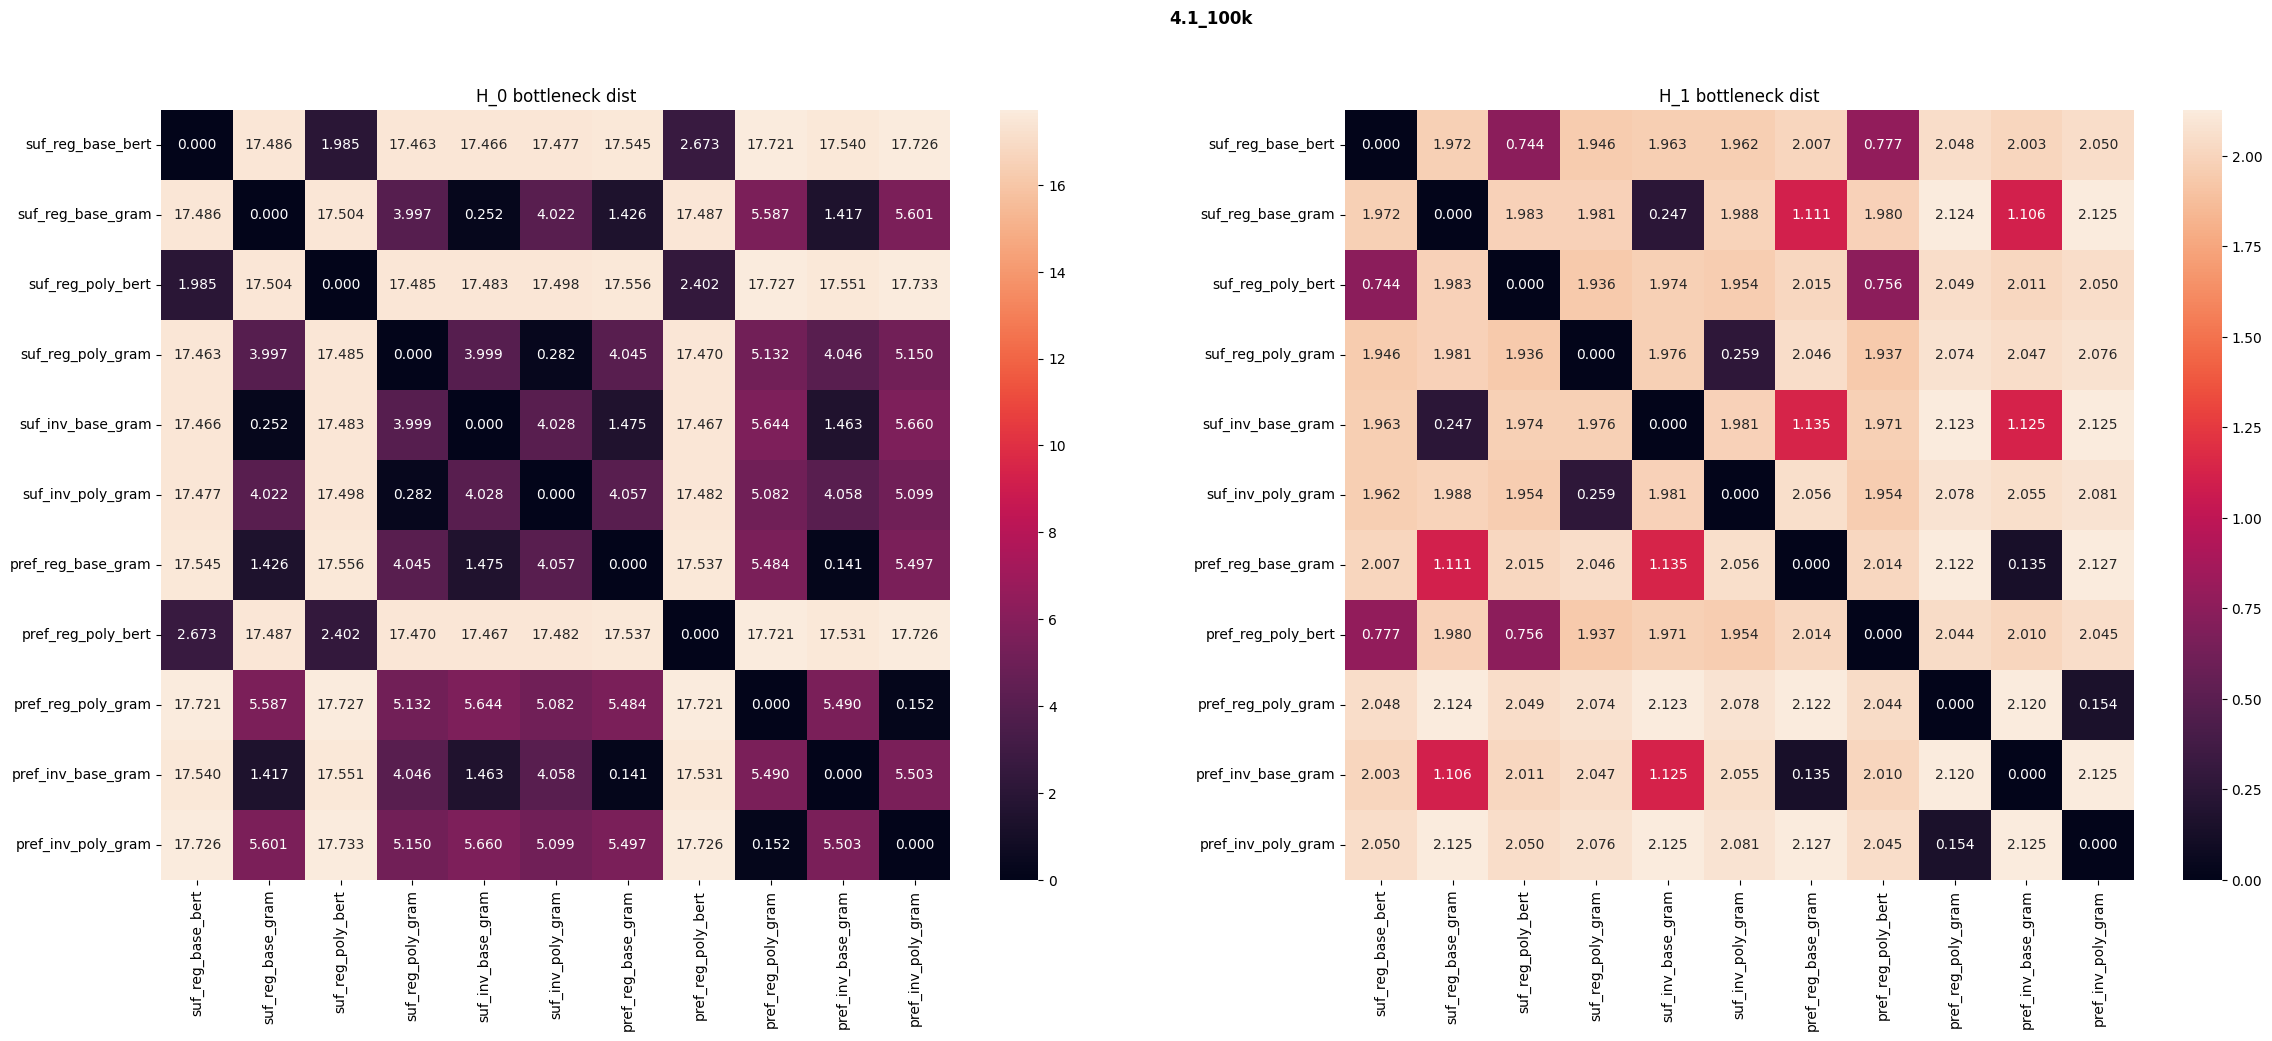

In [10]:
## base

df = pd.read_pickle("../logs/trained_models/grouped/analytics/4.1_100k_stats.dfilt")

model_name = "4.1_100k"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(28, 10), )
sns.heatmap(df[df.was_changed].distance_zero.to_numpy().mean(), ax=ax[0], annot=True, fmt=".3f")
ax[0].set_title("H_0 bottleneck dist")
sns.heatmap(df[df.was_changed].distance_one.to_numpy().mean(), ax=ax[1], annot=True, fmt=".3f")
ax[1].set_title("H_1 bottleneck dist")
plt.suptitle(model_name, fontweight="bold")

#plt.savefig(f"../logs/trained_models/grouped/viz/model_name_dist.png")

#### 4.1

Text(0.5, 0.92, '4.1_100k')

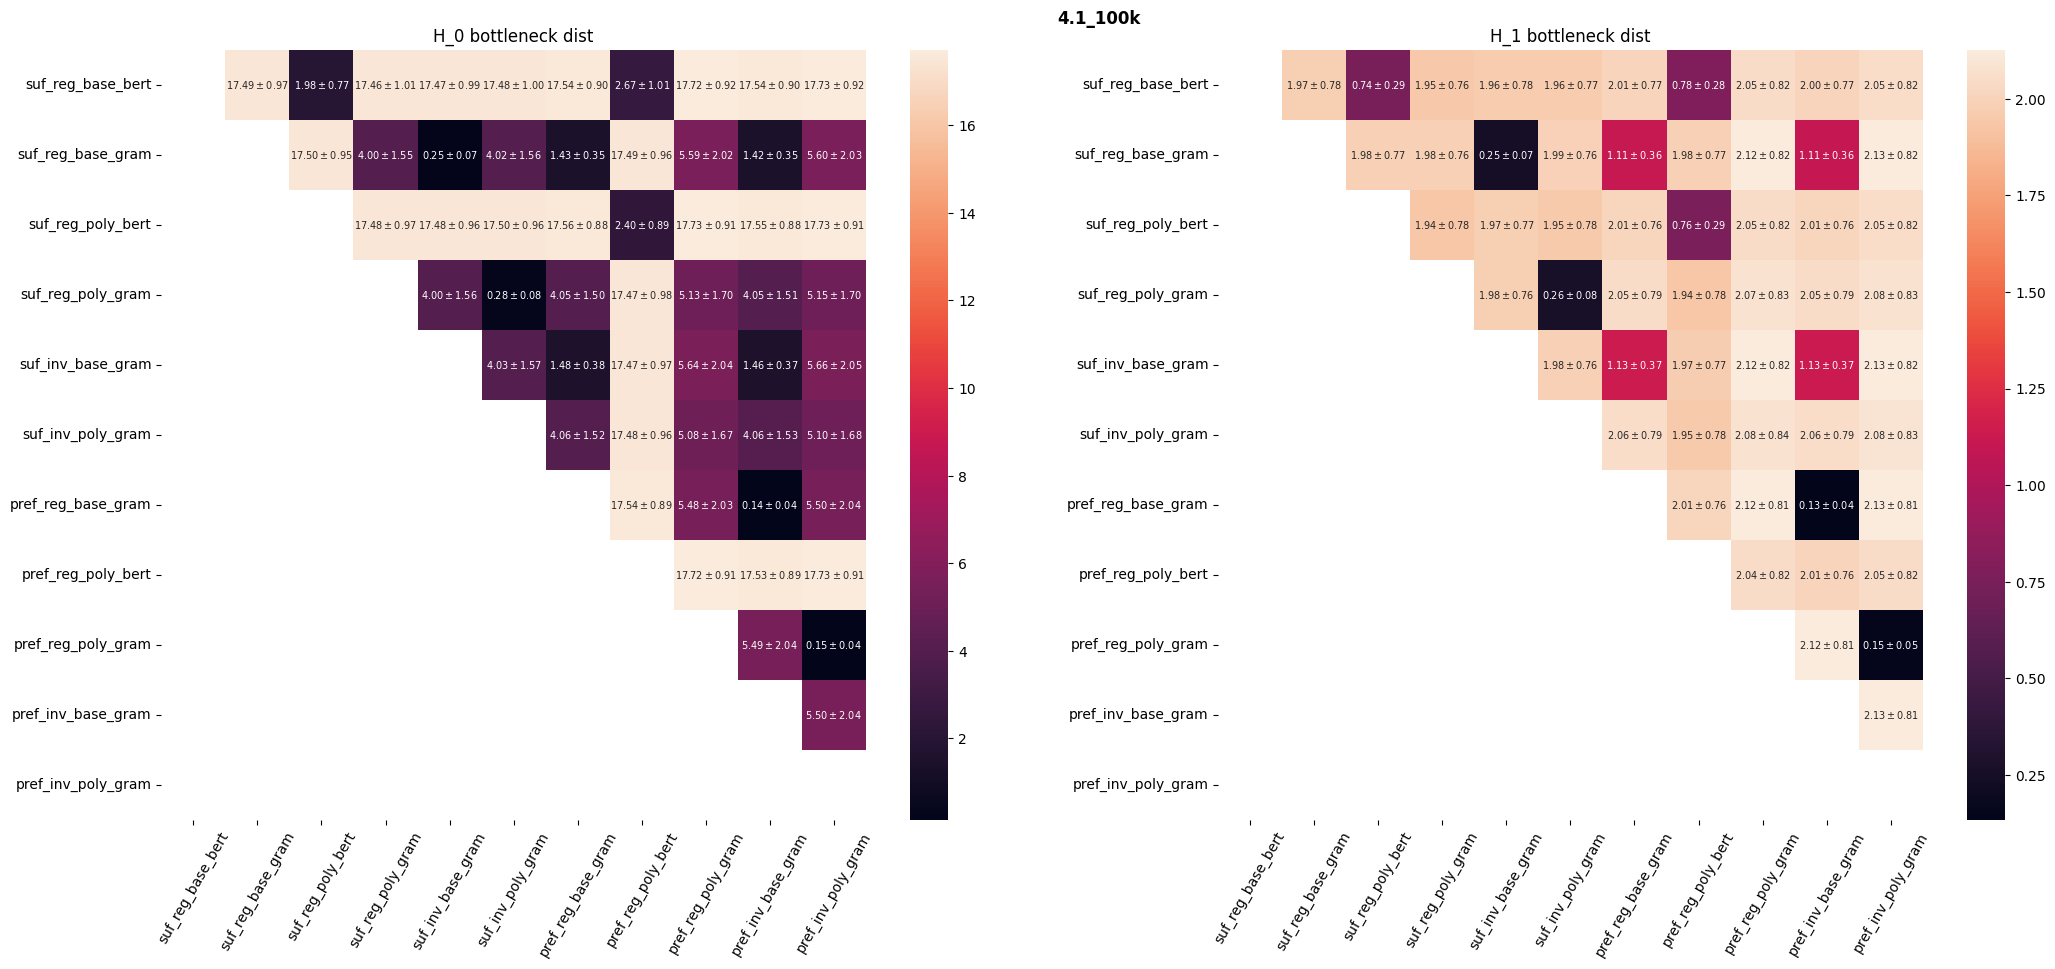

In [27]:
df = pd.read_pickle("../logs/trained_models/grouped/analytics/4.1_100k_stats.dfilt")

model_name = "4.1_100k"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10), )
dfs = df[df.was_changed].distance_zero.to_numpy()
df_std = np.array([x.to_numpy() for x in dfs]).std(axis=0)
df_mean = dfs.mean().to_numpy()
char_df = [["${:.2f}".format(df_mean[i, j]) + "\pm" + "{:.2f}$".format(df_std[i,j]) for i in range(11)] for j in range(11)]
matrix = np.tril(df_mean)
sns.heatmap(df[df.was_changed].distance_zero.to_numpy().mean(), ax=ax[0], annot=char_df, fmt="", annot_kws={"fontsize":7}, mask=matrix)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=60)
ax[0].set_title("H_0 bottleneck dist")

dfs = df[df.was_changed].distance_one.to_numpy()
df_std = np.array([x.to_numpy() for x in dfs]).std(axis=0)
df_mean = dfs.mean().to_numpy()
char_df = [["${:.2f}".format(df_mean[i, j]) + "\pm" + "{:.2f}$".format(df_std[i,j]) for i in range(11)] for j in range(11)]
matrix = np.tril(df_mean)
sns.heatmap(df[df.was_changed].distance_one.to_numpy().mean(), ax=ax[1], annot=char_df, fmt="", annot_kws={"fontsize":7}, mask=matrix)
ax[1].set_xticklabels(ax[0].get_xticklabels(),rotation=60)
ax[1].set_title("H_1 bottleneck dist")


plt.suptitle(model_name, fontweight="bold", y=.92)

#plt.savefig(f"../logs/trained_models/grouped/viz/model_name_dist.png")

[Text(0, 0, 'suf_reg_base_bert'),
 Text(1, 0, 'suf_reg_base_gram'),
 Text(2, 0, 'suf_reg_poly_bert'),
 Text(3, 0, 'suf_reg_poly_gram'),
 Text(4, 0, 'suf_inv_base_gram'),
 Text(5, 0, 'suf_inv_poly_gram'),
 Text(6, 0, 'pref_reg_base_gram'),
 Text(7, 0, 'pref_reg_poly_bert'),
 Text(8, 0, 'pref_reg_poly_gram'),
 Text(9, 0, 'pref_inv_base_gram'),
 Text(10, 0, 'pref_inv_poly_gram')]

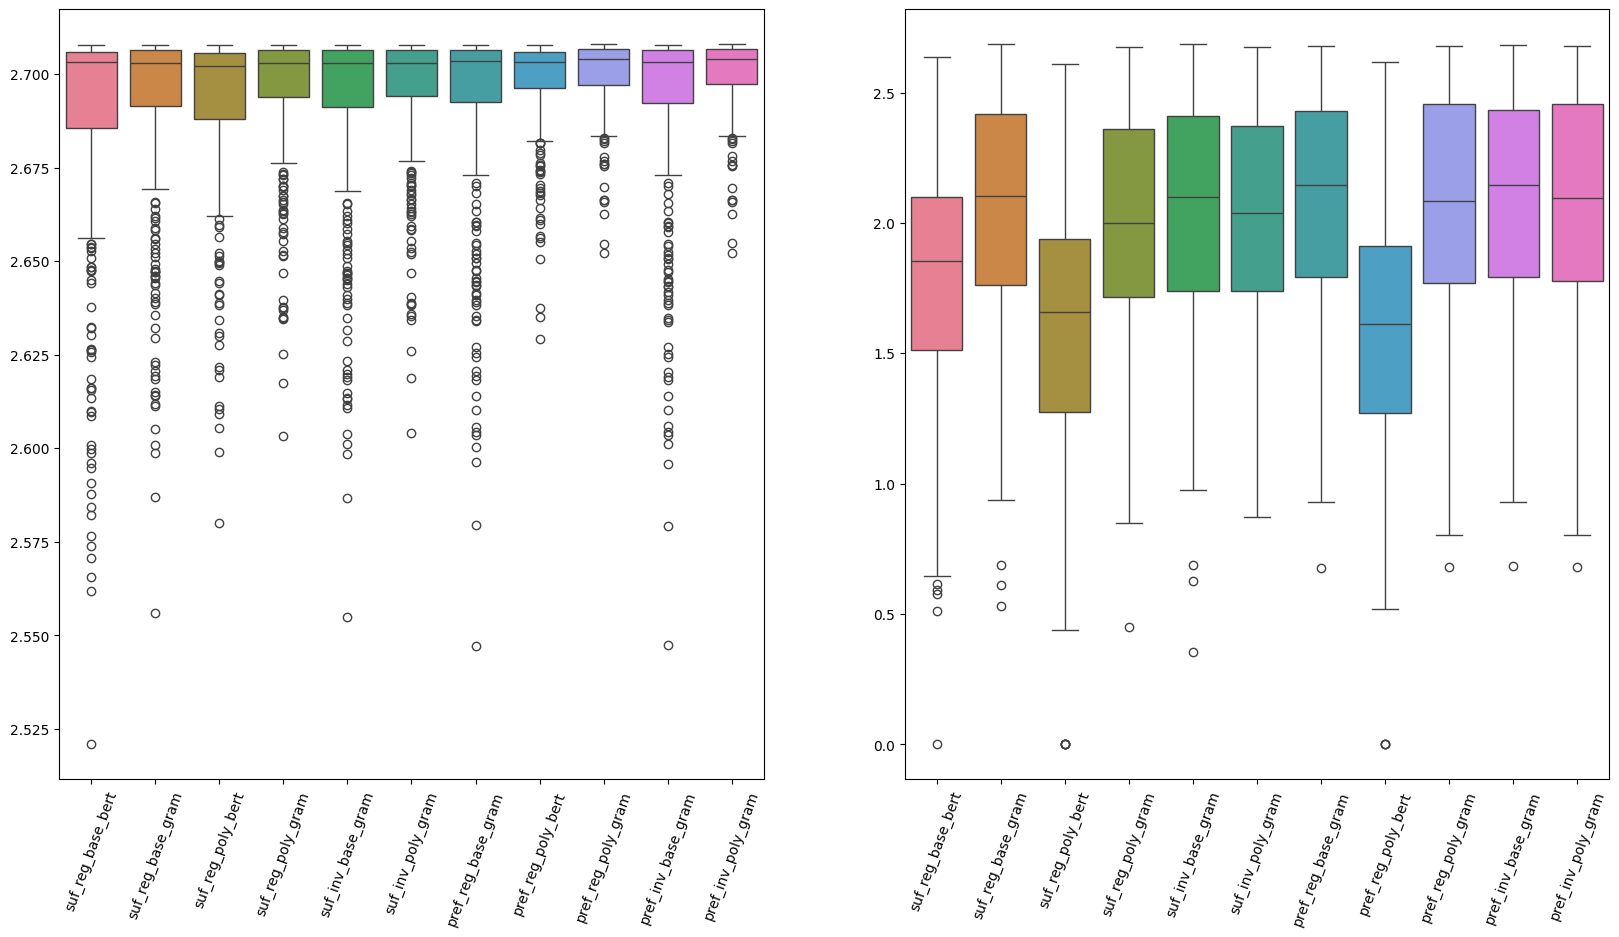

In [282]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("entropy_zero"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[0]
)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
ax[0].set_title("$H_0$ barcodes")

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("entropy_one"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[1]
)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)
ax[1].set_title("$H_1$ barcodes")

plt.suptitle("Barcode entropy distribution", y=0.92)

[Text(0, 0, 'suf_reg_base_bert'),
 Text(1, 0, 'suf_reg_base_gram'),
 Text(2, 0, 'suf_reg_poly_bert'),
 Text(3, 0, 'suf_reg_poly_gram'),
 Text(4, 0, 'suf_inv_base_gram'),
 Text(5, 0, 'suf_inv_poly_gram'),
 Text(6, 0, 'pref_reg_base_gram'),
 Text(7, 0, 'pref_reg_poly_bert'),
 Text(8, 0, 'pref_reg_poly_gram'),
 Text(9, 0, 'pref_inv_base_gram'),
 Text(10, 0, 'pref_inv_poly_gram')]

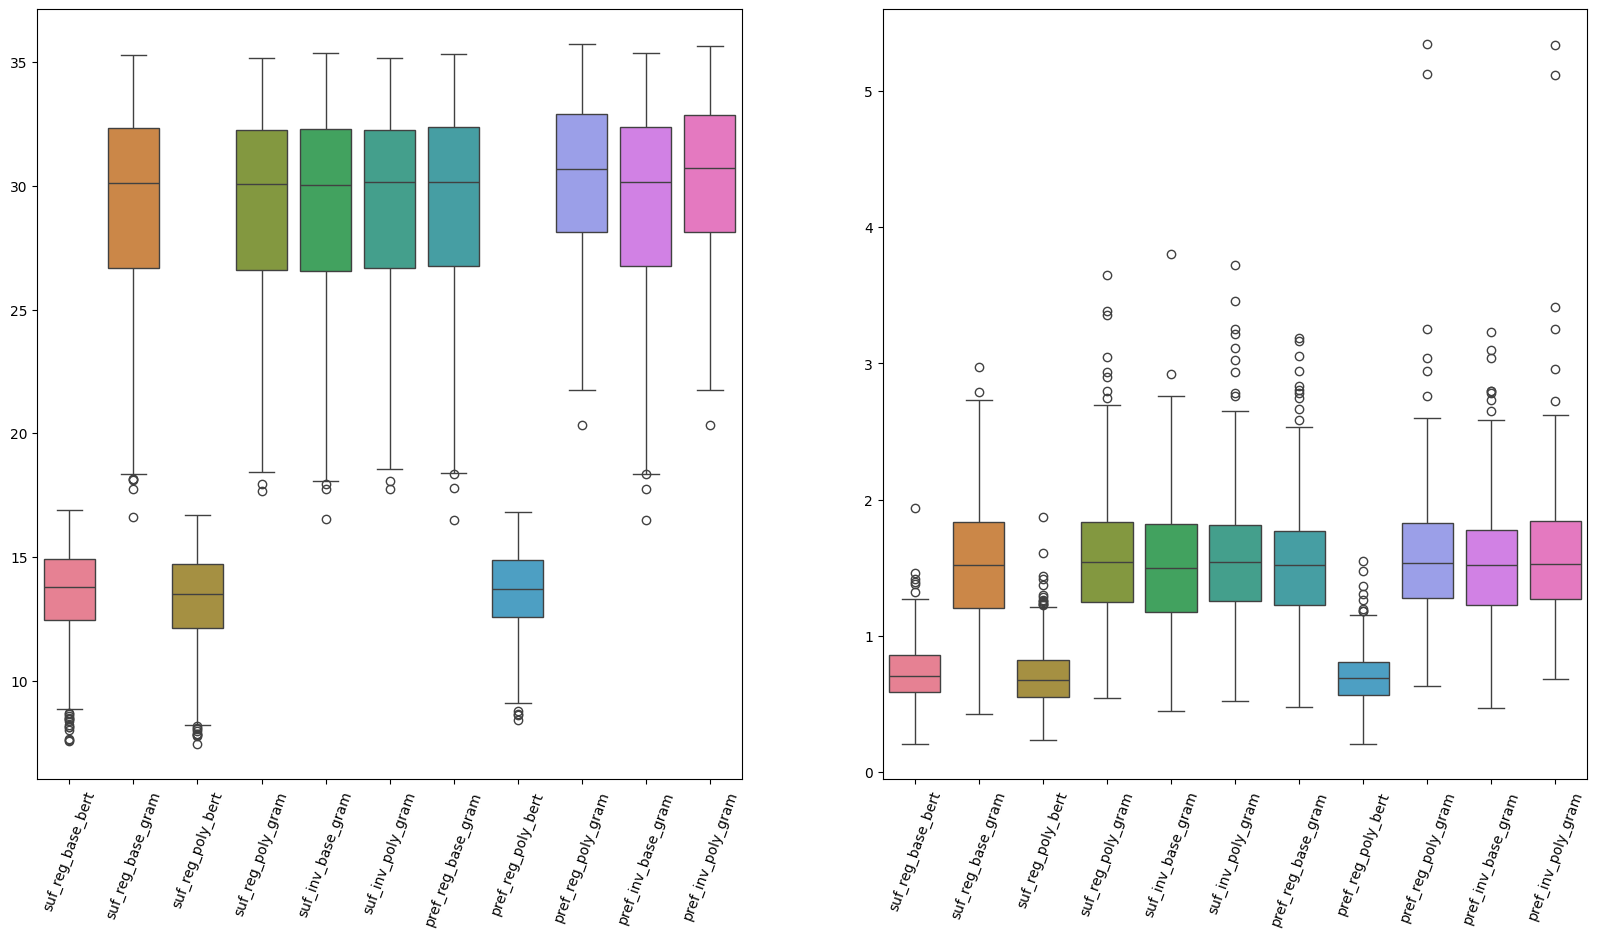

In [283]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("len_zero"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[0]
)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
ax[0].set_title("$H_0$ barcodes")

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("len_one"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[1]
)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)
ax[1].set_title("$H_1$ barcodes")

plt.suptitle("Barcode length distribution", y=0.92)

#### 4.1 full

Text(0.5, 0.98, '4.1_full_100k')

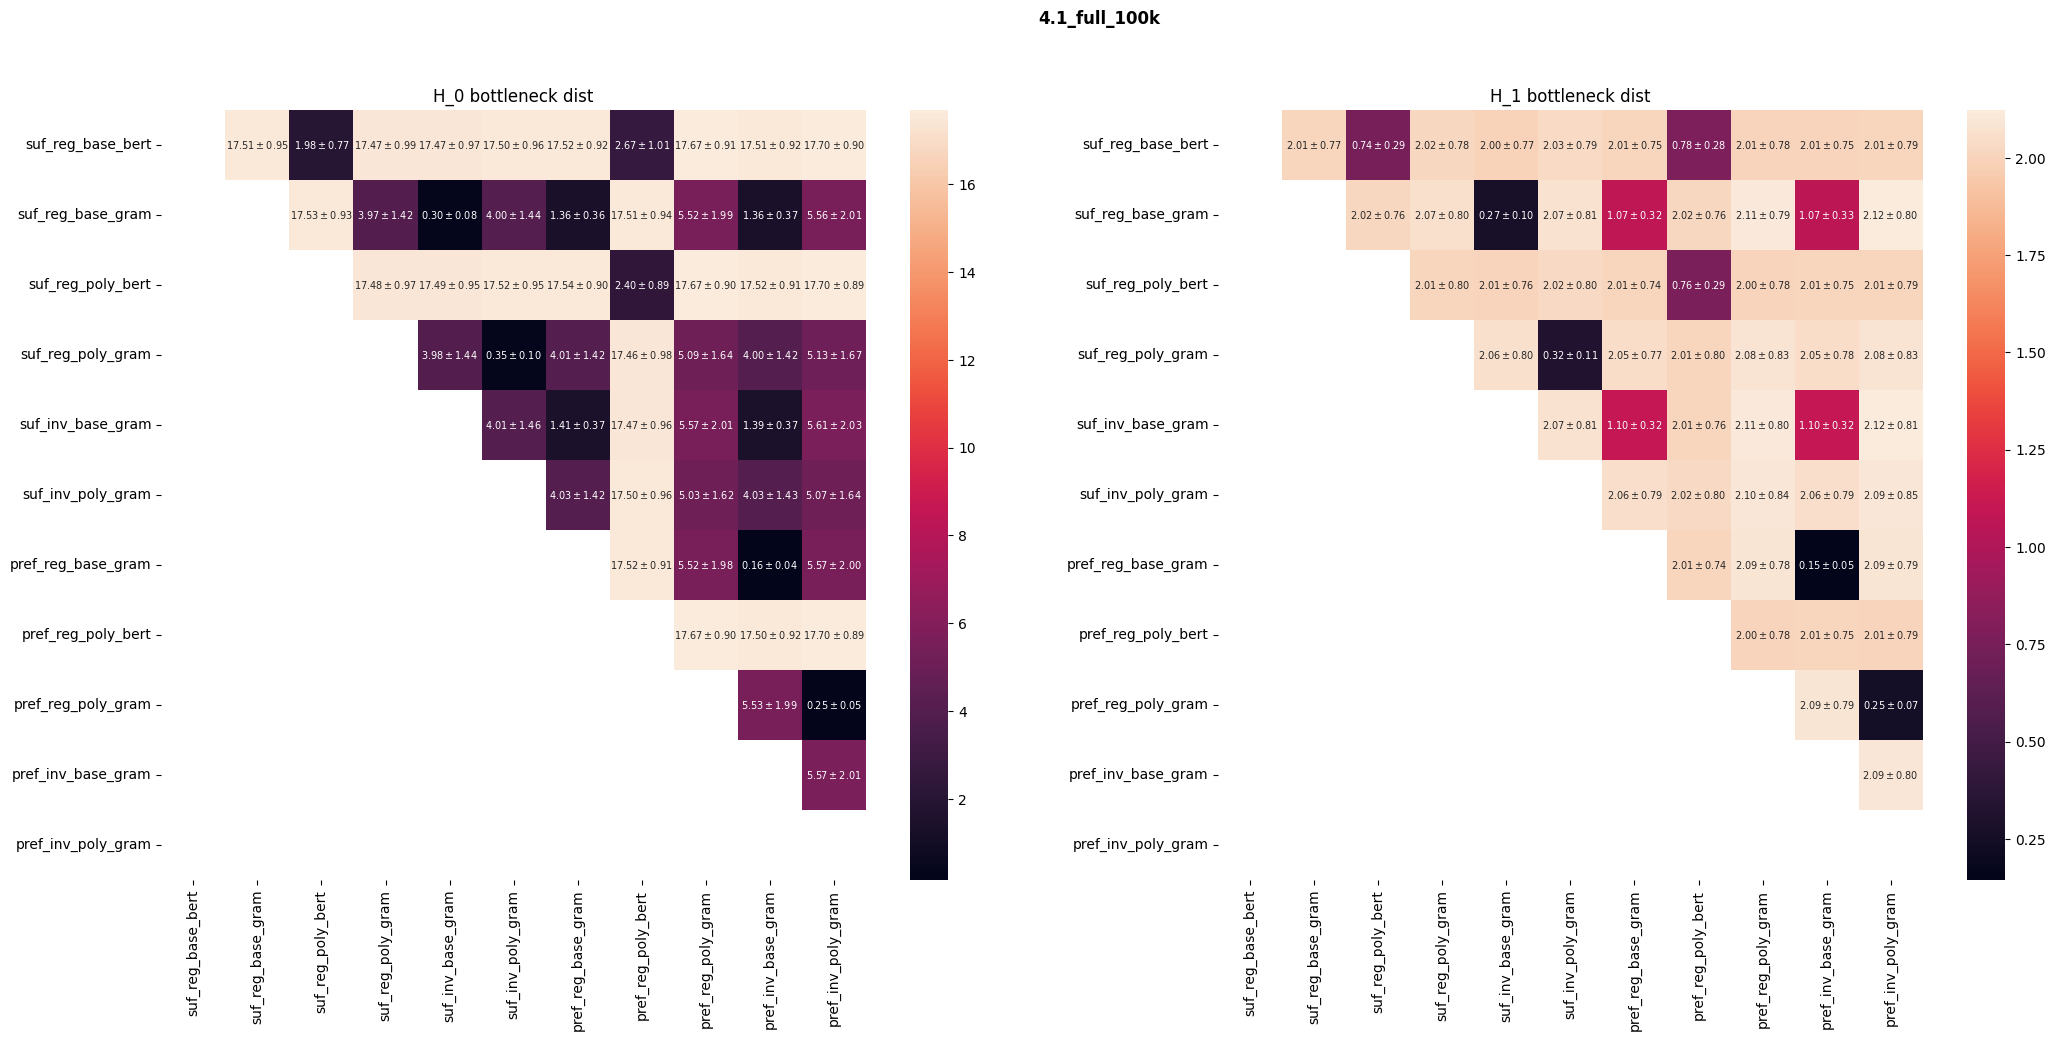

In [11]:
df = pd.read_pickle("../logs/trained_models/grouped/analytics/4.1_full_100k_stats.dfilt")

model_name = "4.1_full_100k"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10), )
dfs = df[df.was_changed].distance_zero.to_numpy()
df_std = np.array([x.to_numpy() for x in dfs]).std(axis=0)
df_mean = dfs.mean().to_numpy()
char_df = [["${:.2f}".format(df_mean[i, j]) + "\pm" + "{:.2f}$".format(df_std[i,j]) for i in range(11)] for j in range(11)]
matrix = np.tril(df_mean)
sns.heatmap(df[df.was_changed].distance_zero.to_numpy().mean(), ax=ax[0], annot=char_df, fmt="", annot_kws={"fontsize":7}, mask=matrix)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=60)
ax[0].set_title("H_0 bottleneck dist")

dfs = df[df.was_changed].distance_one.to_numpy()
df_std = np.array([x.to_numpy() for x in dfs]).std(axis=0)
df_mean = dfs.mean().to_numpy()
char_df = [["${:.2f}".format(df_mean[i, j]) + "\pm" + "{:.2f}$".format(df_std[i,j]) for i in range(11)] for j in range(11)]
matrix = np.tril(df_mean)
sns.heatmap(df[df.was_changed].distance_one.to_numpy().mean(), ax=ax[1], annot=char_df, fmt="", annot_kws={"fontsize":7}, mask=matrix)
ax[1].set_xticklabels(ax[0].get_xticklabels(),rotation=60)
ax[1].set_title("H_1 bottleneck dist")


plt.suptitle(model_name, fontweight="bold", y=.92)

#plt.savefig(f"../logs/trained_models/grouped/viz/model_name_dist.png")

/tmp/ipykernel_373638/2561568070.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
/tmp/ipykernel_373638/2561568070.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)


[Text(0, 0, 'suf_reg_base_bert'),
 Text(1, 0, 'suf_reg_base_gram'),
 Text(2, 0, 'suf_reg_poly_bert'),
 Text(3, 0, 'suf_reg_poly_gram'),
 Text(4, 0, 'suf_inv_base_gram'),
 Text(5, 0, 'suf_inv_poly_gram'),
 Text(6, 0, 'pref_reg_base_gram'),
 Text(7, 0, 'pref_reg_poly_bert'),
 Text(8, 0, 'pref_reg_poly_gram'),
 Text(9, 0, 'pref_inv_base_gram'),
 Text(10, 0, 'pref_inv_poly_gram')]

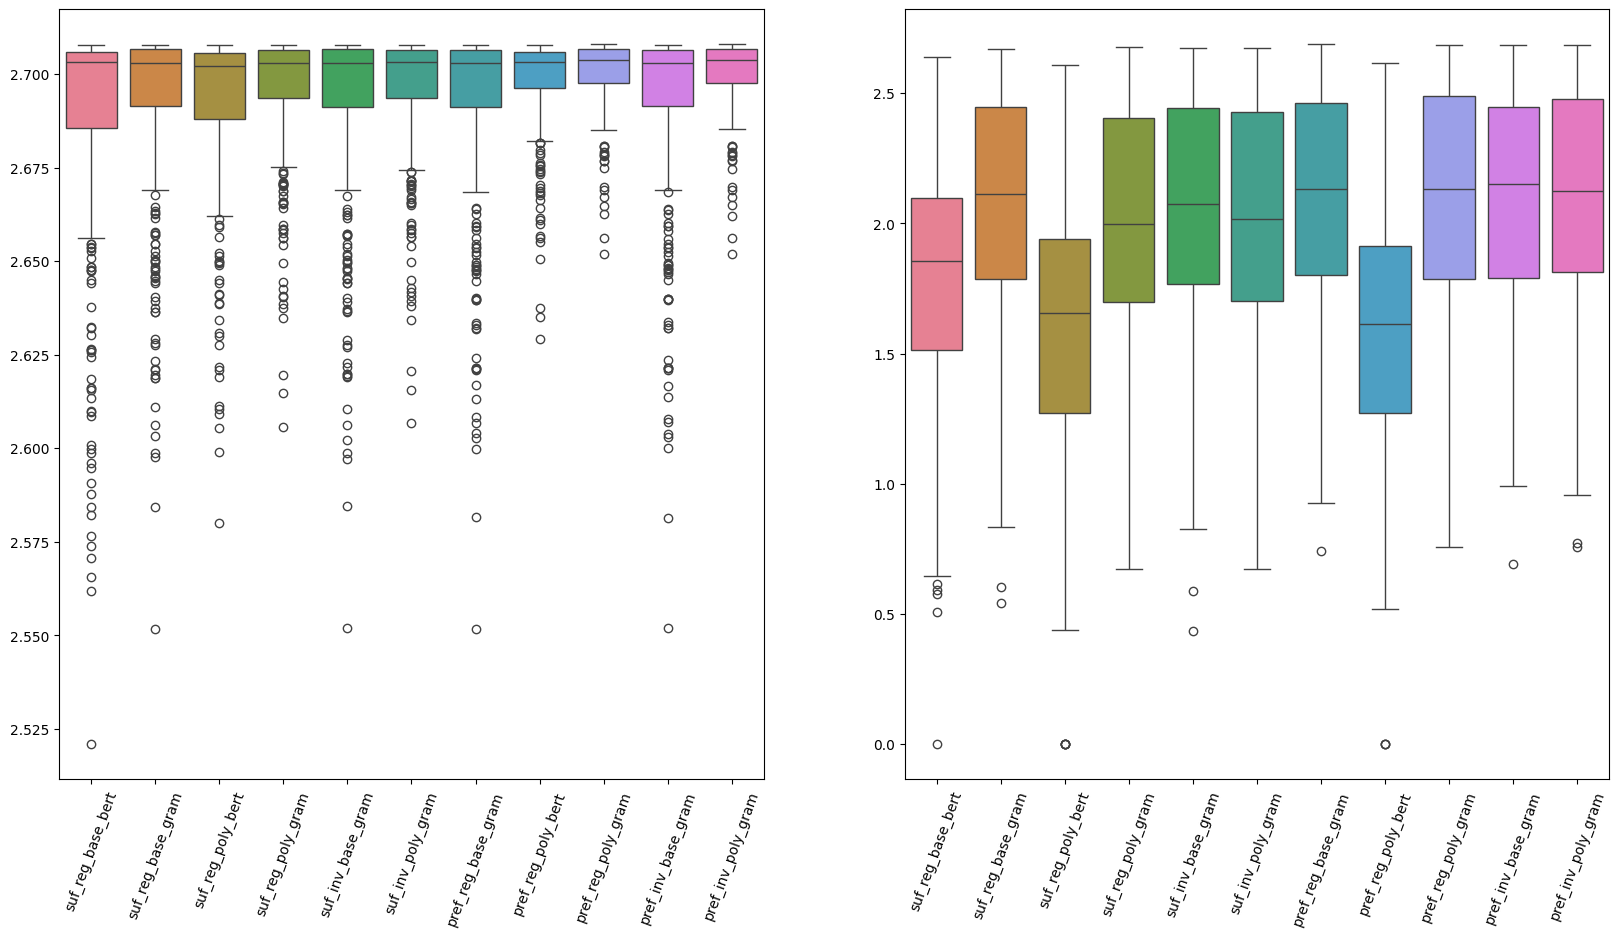

In [12]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("entropy_zero"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[0]
)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
ax[0].set_title("$H_0$ barcodes")

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("entropy_one"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[1]
)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)
ax[1].set_title("$H_1$ barcodes")

plt.suptitle("Barcode entropy distribution", y=0.92)

/tmp/ipykernel_373638/3204419651.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
/tmp/ipykernel_373638/3204419651.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)


[Text(0, 0, 'suf_reg_base_bert'),
 Text(1, 0, 'suf_reg_base_gram'),
 Text(2, 0, 'suf_reg_poly_bert'),
 Text(3, 0, 'suf_reg_poly_gram'),
 Text(4, 0, 'suf_inv_base_gram'),
 Text(5, 0, 'suf_inv_poly_gram'),
 Text(6, 0, 'pref_reg_base_gram'),
 Text(7, 0, 'pref_reg_poly_bert'),
 Text(8, 0, 'pref_reg_poly_gram'),
 Text(9, 0, 'pref_inv_base_gram'),
 Text(10, 0, 'pref_inv_poly_gram')]

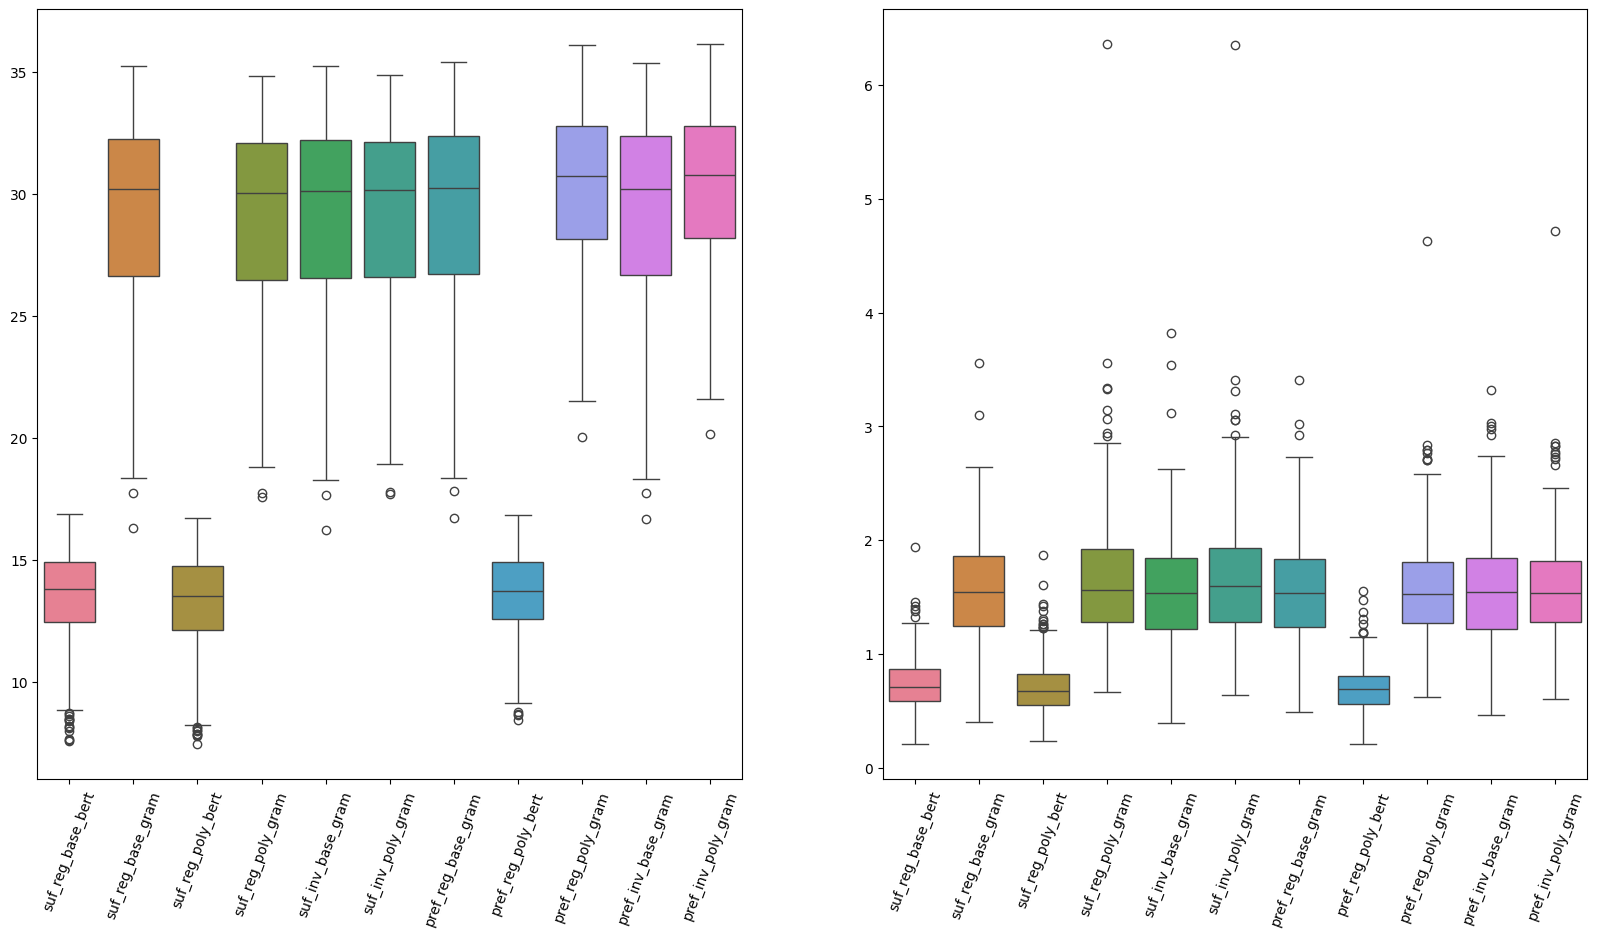

In [13]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("len_zero"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[0]
)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
ax[0].set_title("$H_0$ barcodes")

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("len_one"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[1]
)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)
ax[1].set_title("$H_1$ barcodes")

plt.suptitle("Barcode length distribution", y=0.92)

#### 4.2.1

Text(0.5, 0.92, '4.2.1_100k')

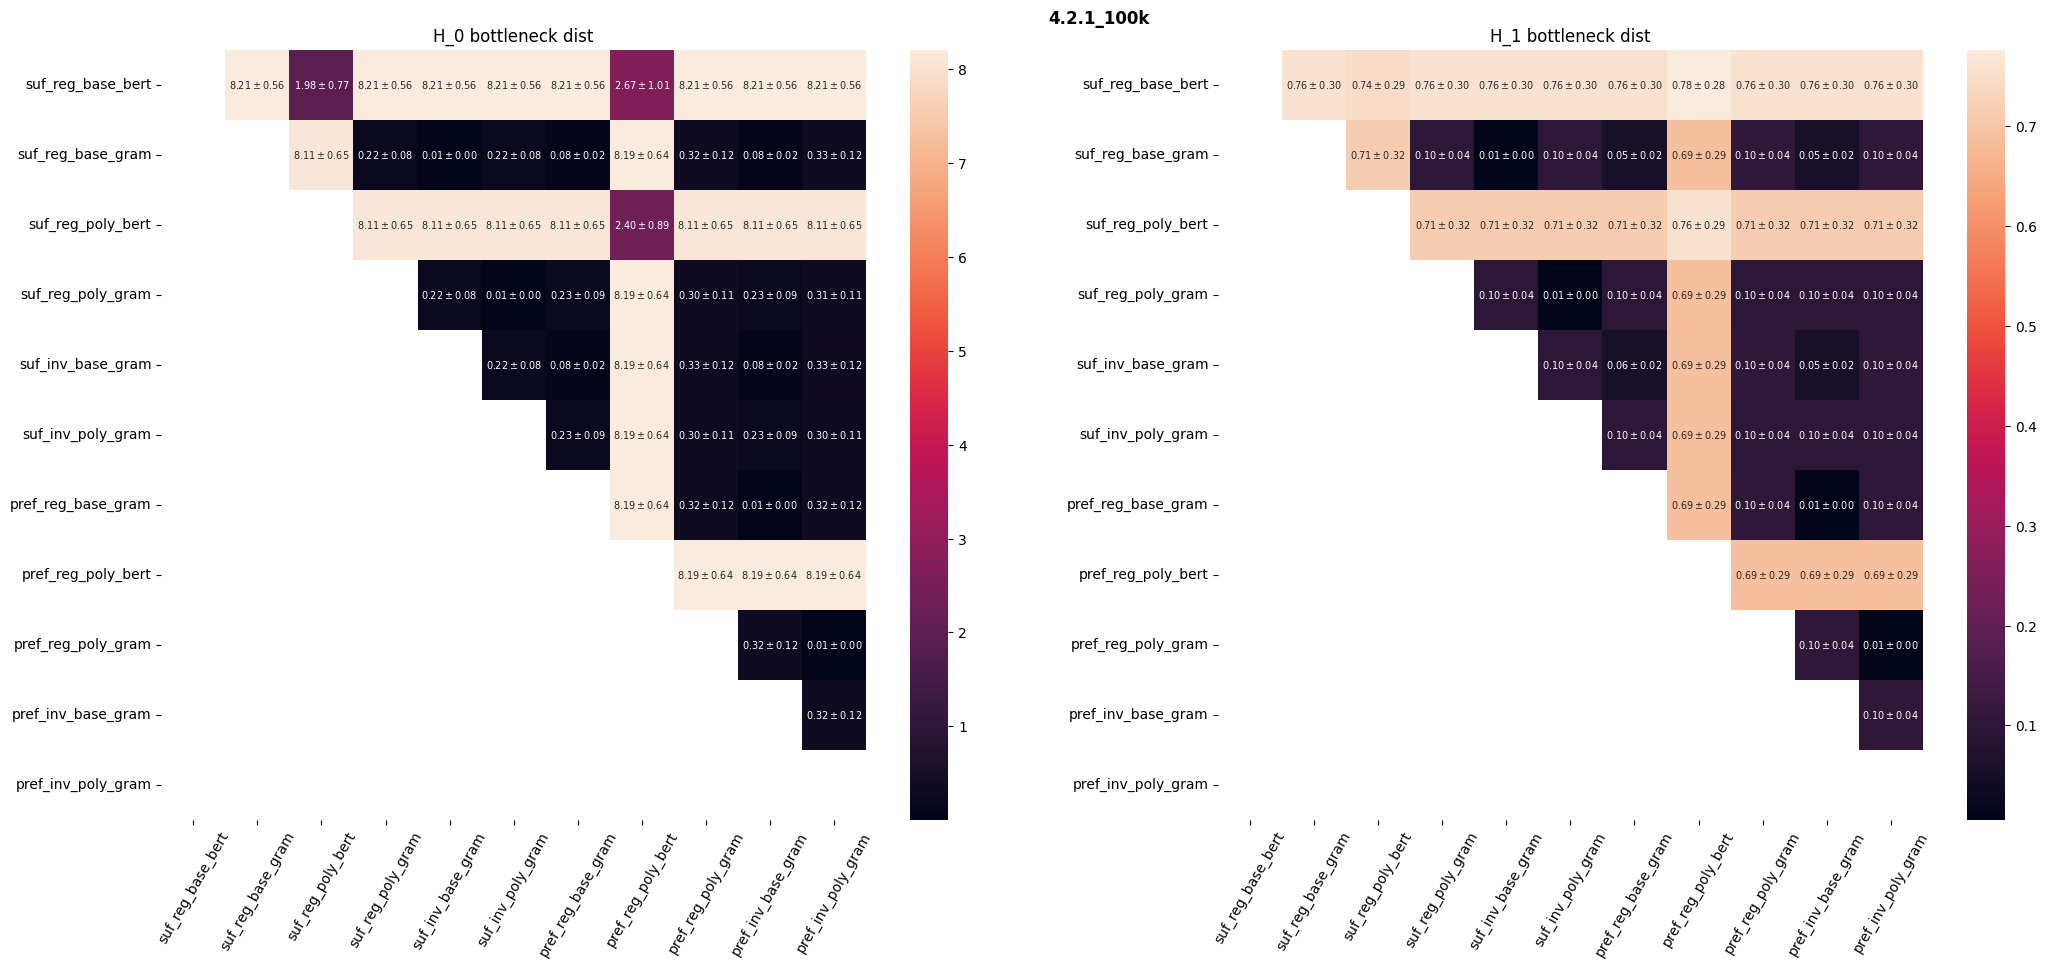

In [28]:
df = pd.read_pickle("../logs/trained_models/grouped/analytics/4.2.1_100k_stats.dfilt")

model_name = "4.2.1_100k"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10), )
dfs = df[df.was_changed].distance_zero.to_numpy()
df_std = np.array([x.to_numpy() for x in dfs]).std(axis=0)
df_mean = dfs.mean().to_numpy()
char_df = [["${:.2f}".format(df_mean[i, j]) + "\pm" + "{:.2f}$".format(df_std[i,j]) for i in range(11)] for j in range(11)]
matrix = np.tril(df_mean)
sns.heatmap(df[df.was_changed].distance_zero.to_numpy().mean(), ax=ax[0], annot=char_df, fmt="", annot_kws={"fontsize":7}, mask=matrix)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=60)
ax[0].set_title("H_0 bottleneck dist")

dfs = df[df.was_changed].distance_one.to_numpy()
df_std = np.array([x.to_numpy() for x in dfs]).std(axis=0)
df_mean = dfs.mean().to_numpy()
char_df = [["${:.2f}".format(df_mean[i, j]) + "\pm" + "{:.2f}$".format(df_std[i,j]) for i in range(11)] for j in range(11)]
matrix = np.tril(df_mean)
sns.heatmap(df[df.was_changed].distance_one.to_numpy().mean(), ax=ax[1], annot=char_df, fmt="", annot_kws={"fontsize":7}, mask=matrix)
ax[1].set_xticklabels(ax[0].get_xticklabels(),rotation=60)
ax[1].set_title("H_1 bottleneck dist")


plt.suptitle(model_name, fontweight="bold", y=.92)

#plt.savefig(f"../logs/trained_models/grouped/viz/model_name_dist.png")

/tmp/ipykernel_373638/3331876758.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
/tmp/ipykernel_373638/3331876758.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)


Text(0.5, 0.92, 'Barcode entropy distribution')

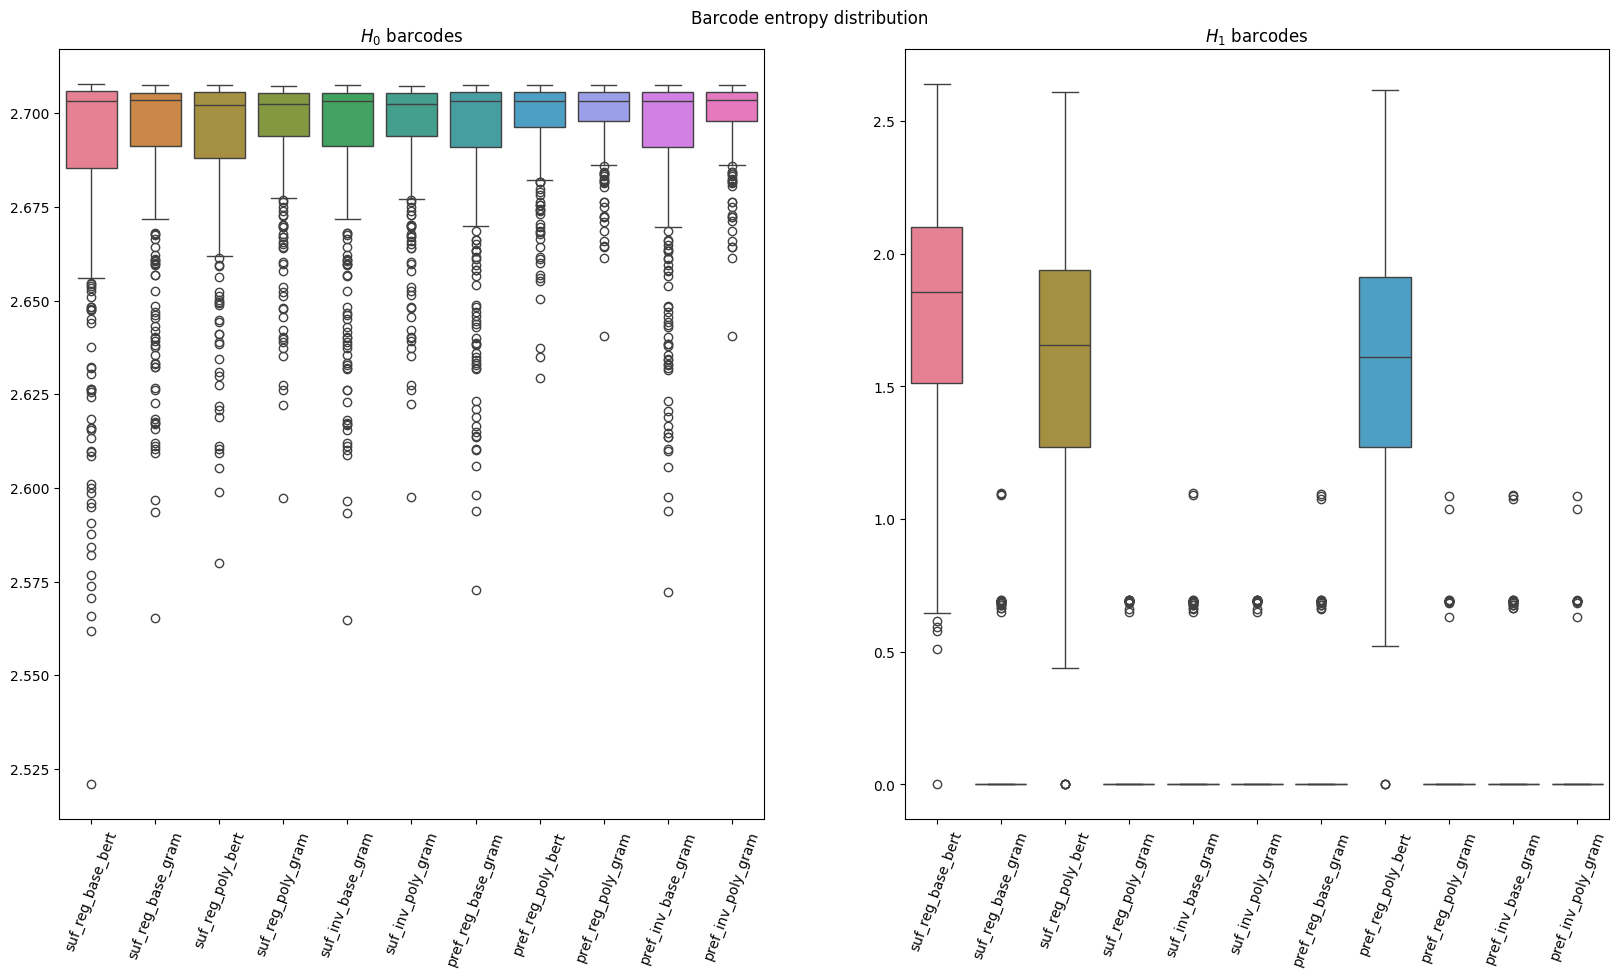

In [29]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("entropy_zero"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[0]
)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
ax[0].set_title("$H_0$ barcodes")

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("entropy_one"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[1]
)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)
ax[1].set_title("$H_1$ barcodes")

plt.suptitle("Barcode entropy distribution", y=0.92)

/tmp/ipykernel_373638/129149299.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
/tmp/ipykernel_373638/129149299.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)


Text(0.5, 0.92, 'Barcode length distribution')

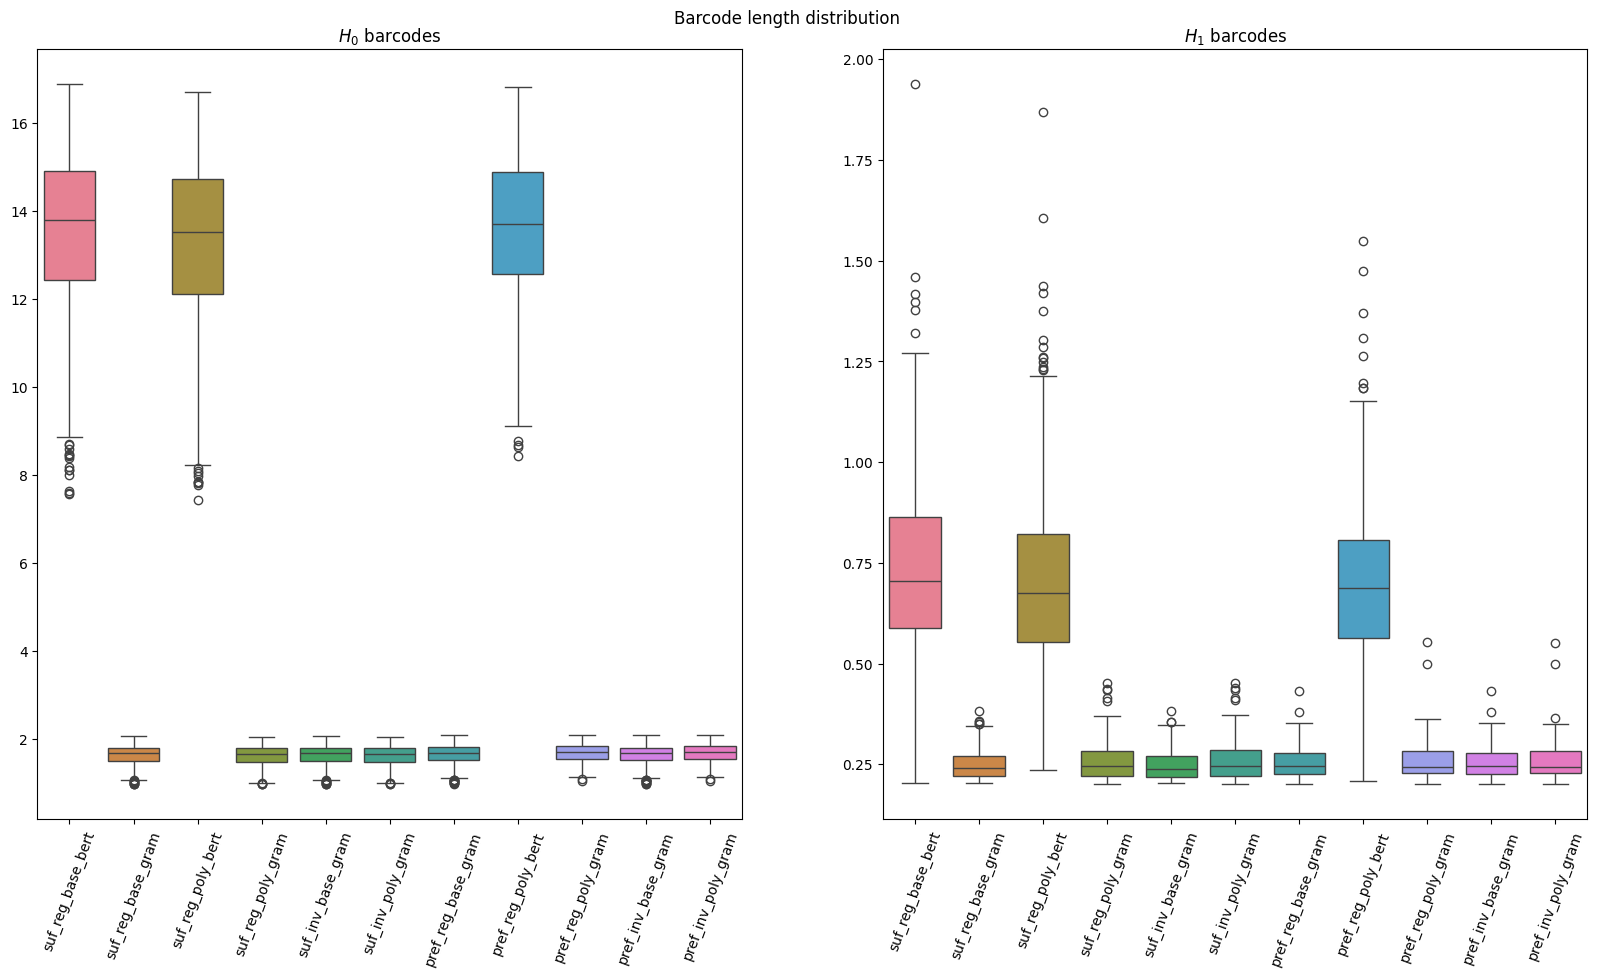

In [30]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("len_zero"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[0]
)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
ax[0].set_title("$H_0$ barcodes")

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("len_one"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[1]
)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)
ax[1].set_title("$H_1$ barcodes")

plt.suptitle("Barcode length distribution", y=0.92)

#### 4.2.1 full

Text(0.5, 0.92, '4.2.1_full_100k')

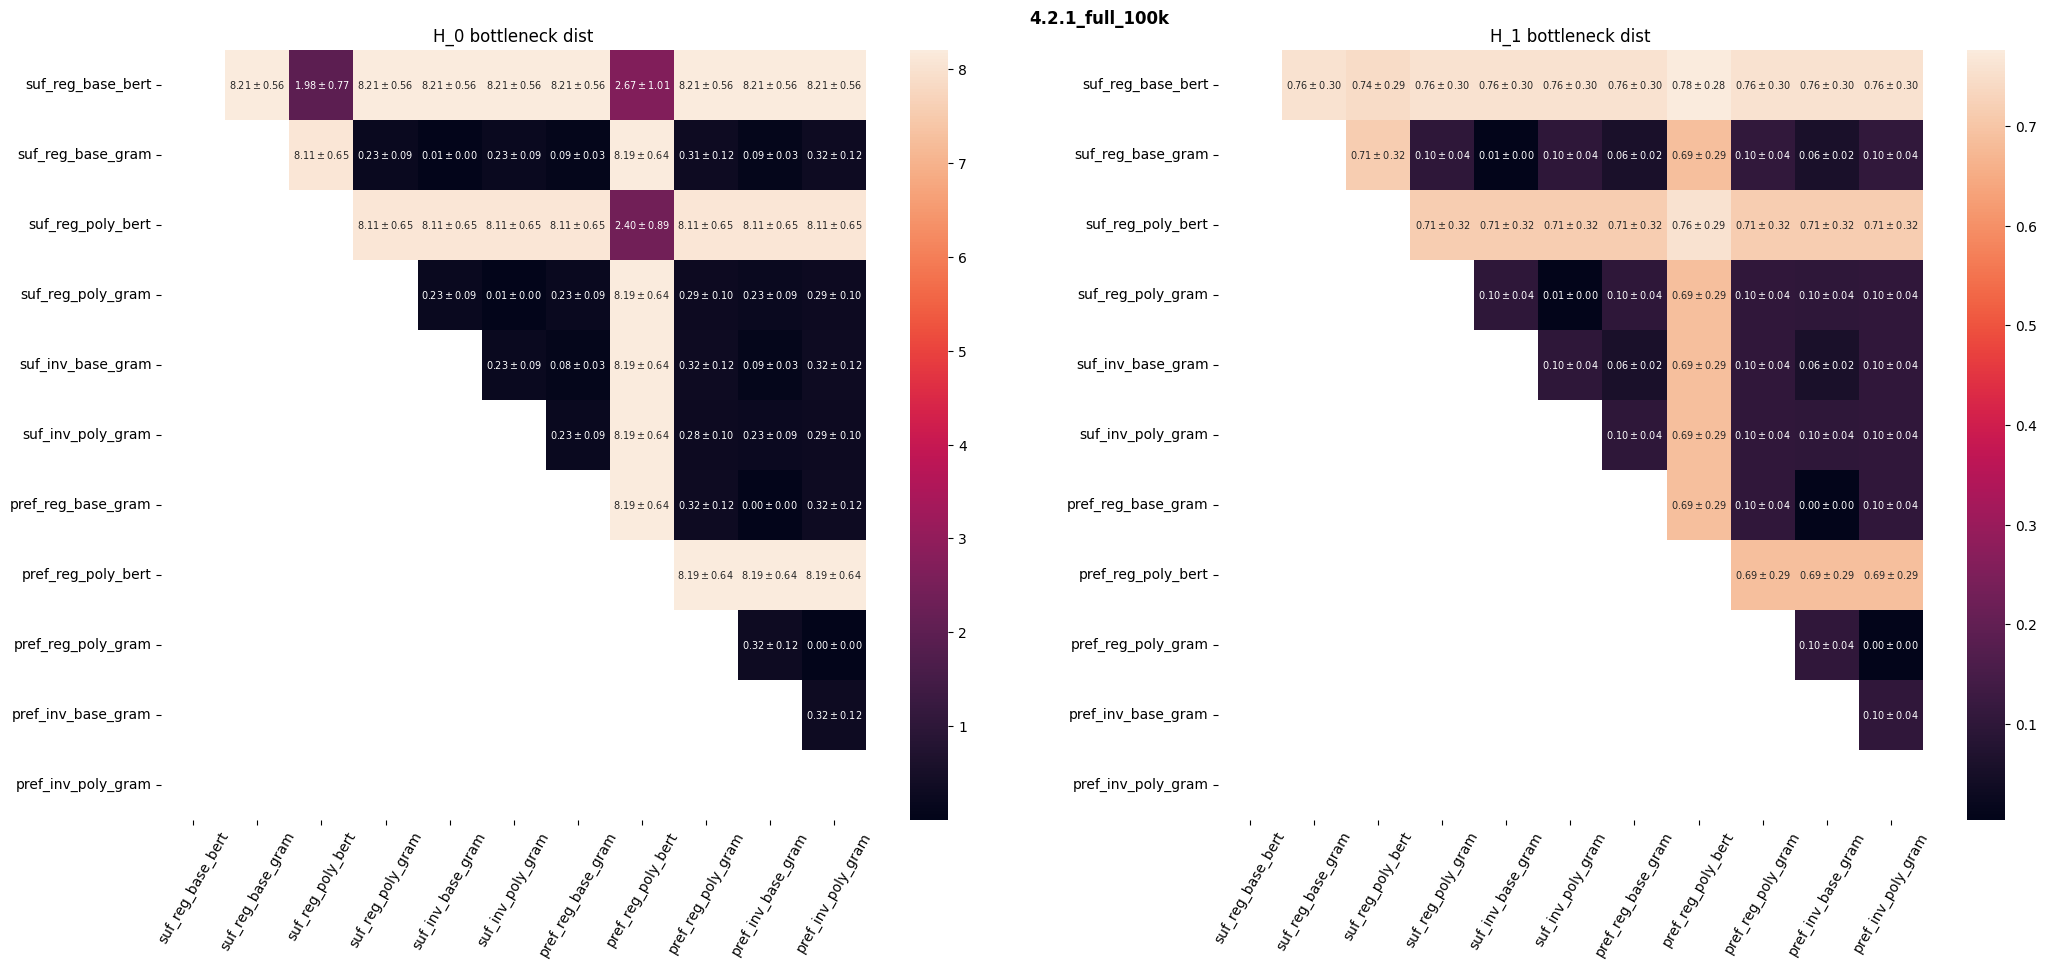

In [31]:
df = pd.read_pickle("../logs/trained_models/grouped/analytics/4.2.1_full_100k_stats.dfilt")

model_name = "4.2.1_full_100k"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10), )
dfs = df[df.was_changed].distance_zero.to_numpy()
df_std = np.array([x.to_numpy() for x in dfs]).std(axis=0)
df_mean = dfs.mean().to_numpy()
char_df = [["${:.2f}".format(df_mean[i, j]) + "\pm" + "{:.2f}$".format(df_std[i,j]) for i in range(11)] for j in range(11)]
matrix = np.tril(df_mean)
sns.heatmap(df[df.was_changed].distance_zero.to_numpy().mean(), ax=ax[0], annot=char_df, fmt="", annot_kws={"fontsize":7}, mask=matrix)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=60)
ax[0].set_title("H_0 bottleneck dist")

dfs = df[df.was_changed].distance_one.to_numpy()
df_std = np.array([x.to_numpy() for x in dfs]).std(axis=0)
df_mean = dfs.mean().to_numpy()
char_df = [["${:.2f}".format(df_mean[i, j]) + "\pm" + "{:.2f}$".format(df_std[i,j]) for i in range(11)] for j in range(11)]
matrix = np.tril(df_mean)
sns.heatmap(df[df.was_changed].distance_one.to_numpy().mean(), ax=ax[1], annot=char_df, fmt="", annot_kws={"fontsize":7}, mask=matrix)
ax[1].set_xticklabels(ax[0].get_xticklabels(),rotation=60)
ax[1].set_title("H_1 bottleneck dist")


plt.suptitle(model_name, fontweight="bold", y=.92)

#plt.savefig(f"../logs/trained_models/grouped/viz/model_name_dist.png")

/tmp/ipykernel_373638/3331876758.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
/tmp/ipykernel_373638/3331876758.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)


Text(0.5, 0.92, 'Barcode entropy distribution')

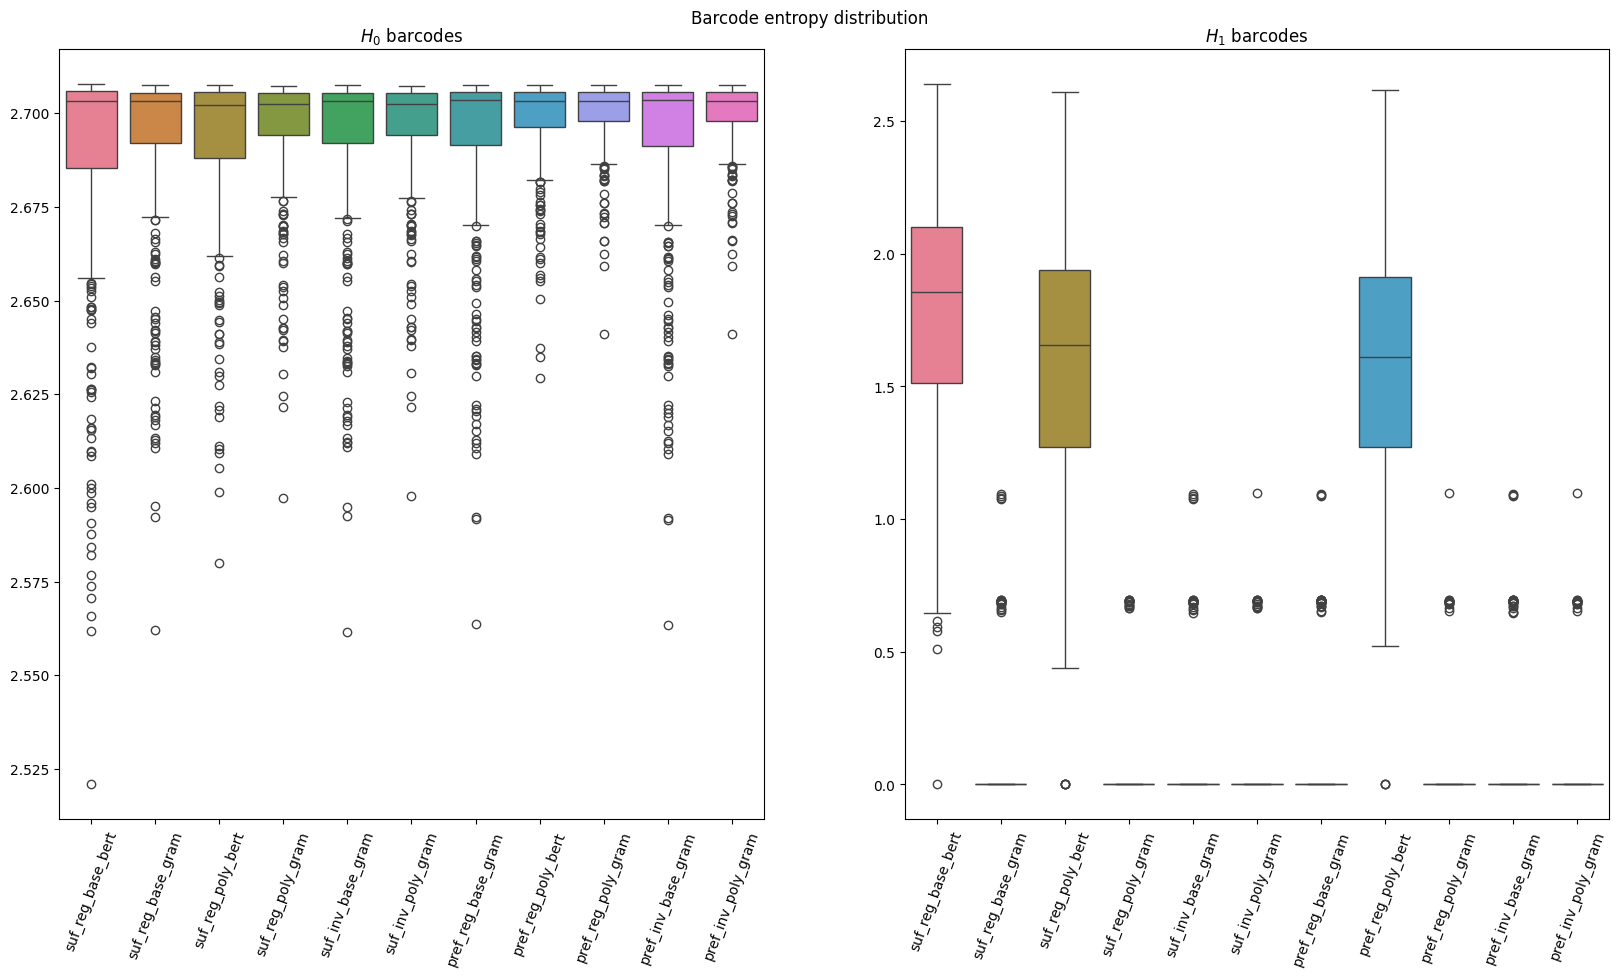

In [32]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("entropy_zero"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[0]
)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
ax[0].set_title("$H_0$ barcodes")

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("entropy_one"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[1]
)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)
ax[1].set_title("$H_1$ barcodes")

plt.suptitle("Barcode entropy distribution", y=0.92)

/tmp/ipykernel_373638/129149299.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
/tmp/ipykernel_373638/129149299.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)


Text(0.5, 0.92, 'Barcode length distribution')

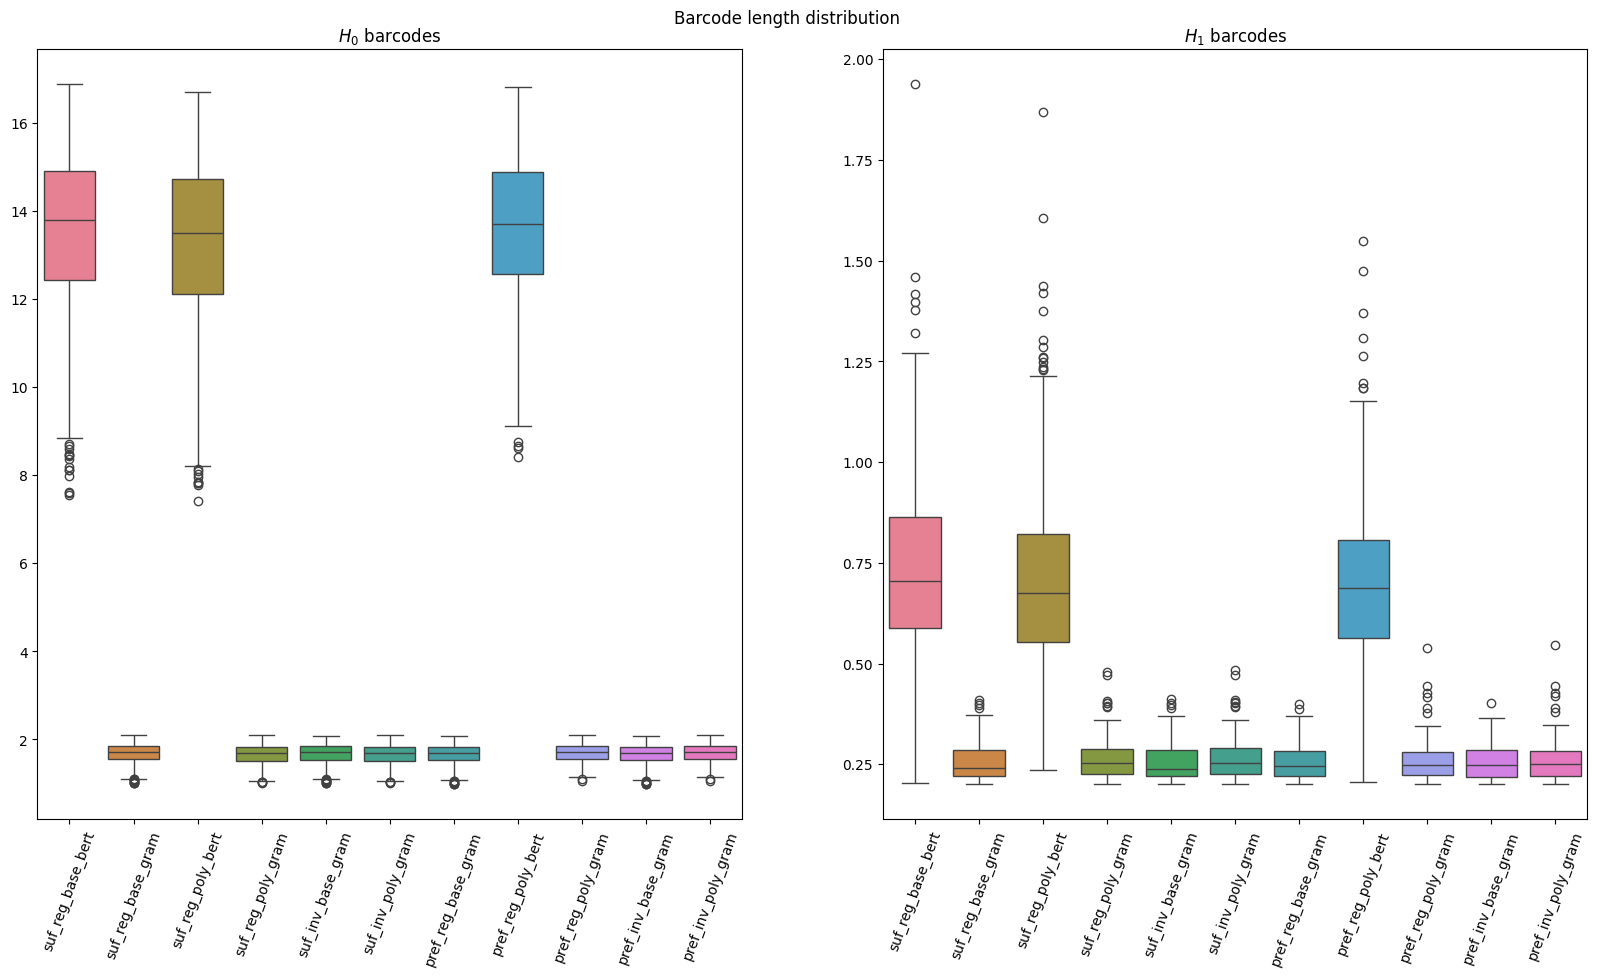

In [33]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("len_zero"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[0]
)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
ax[0].set_title("$H_0$ barcodes")

sns.boxplot(
    df.loc[(df.was_changed), (df.columns.str.contains("len_one"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
    ax=ax[1]
)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)
ax[1].set_title("$H_1$ barcodes")

plt.suptitle("Barcode length distribution", y=0.92)

In [183]:
MODEL_NAME

'DeepPavlov/rubert-base-cased'

In [186]:
import ecco


In [216]:
model_config = {
    'embedding': "bert_module.bert.embeddings.word_embeddings",
    'type': 'mlm',
    'activations': ['intermediate\.dense', 'linear_stack'], #This is a regex
    'token_prefix': '##',
    'partial_token_prefix': '',
    'tokenizer_config': '',
}

In [224]:
ecco_model = ecco.lm.LM(model, tokenizer, model_name='DeepPavlov/rubert-base-cased', config=model_config, collect_activations_flag=True)

In [225]:
text = df["polypers"][0]

In [226]:
inputs = ecco_model.tokenizer(text, return_tensors="pt", max_length=SEQ_LEN, truncation=True, padding="max_length")

In [227]:
inputs["poly_flag"] = torch.tensor([1])

inputs = {k: v.to(device) for k, v in inputs.items()}

In [228]:
ecco_model(inputs,)

<IPython.core.display.Javascript object>